# Team Comparision Notebook
### Adapting code from previous season FF_Viz_Workbook
- will be used to create plots that compare teams
    - Head to head
    - Groups of 4 (will be useful for tourneys)
    - Entire Conference - likely just the scatter plots


##### Dependencies

In [48]:
# Dependencies

# Basics
import os
import sys
import time
import sqlite3

# Data manipulation
import numpy as np
import pandas as pd
from scipy.ndimage import rotate

# Matplot lib and seaborn with sublibraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.legend_handler import HandlerTuple
from matplotlib.legend_handler import HandlerBase
from matplotlib import font_manager

from PIL import Image



##### File Paths

In [49]:
## Load The Exo 2 font in case of problems with the font
font_path = 'C:/Windows/Fonts/Exo 2.tff'
locations =['../data/Exo_2'] # Font Location

font_files = font_manager.findSystemFonts(fontpaths=locations)

for file in font_files:
    font_manager.fontManager.addfont(file)


In [50]:
## Set the date to appear on the source area of plots (the last date of the data)
last_game_date = '2024-12-22'

## File Paths
folder_prefix = ''
# folder_prefix = '..'
data_folder = os.path.join(folder_prefix, '..', 'data/') # Data Folder Path
temp_folder = os.path.join(folder_prefix,'..', 'TEMP/',) # Temp Folder Path
TEMP_FOLDER = temp_folder # Temp Folder Path as used in legacy code
# data\db\2024_Dec_10_CLEANED_OLD_METHOD.db
db_path = os.path.join(data_folder, 'db', '2024_Dec_18_TEST.db') # Database Path
# db_path = os.path.join(data_folder, 'db', '2024_Dec_03_v4_ROUGH.db') # Database Path
# db_path = os.path.join(temp_folder, '2024_Dec_03_v3_ROUGH.db') # Database Path
image_folder = os.path.join(folder_prefix, '..', 'images/') # Image Folder Path
logo_folder = os.path.join(folder_prefix, image_folder, 'logos/') # Logo Folder Path
conference_logo_folder = os.path.join(folder_prefix, logo_folder, 'conference') # Conference Logo Folder Path
export_folder = os.path.join(folder_prefix, image_folder, 'export/') # Export Folder Path
background_folder = os.path.join(folder_prefix, image_folder, 'background/') # Background Folder Path

# Other paths
school_info_path = os.path.join(data_folder, 'arena_school_info.csv') # School Info Path

# make sure connection to the database is colosed
# conn.close()
## Other Variables that are so far unavailable
# pairwise_path = os.path.join(data_folder, 'pairwise') # Current Pairwise Folder Path
# pairwise_df = pd.read_csv(os.path.join(pairwise_path)

##### Start Loading data

In [51]:
## Load the database
conn = sqlite3.connect(db_path, isolation_level=None)

# load the master roster table from the database
main_roster_df = pd.read_sql_query("SELECT * FROM master_roster", conn)
# main_roster_df.head() # Check the data

#### Hotfix cleck and clean all Team names for . - ect

In [52]:
def clean_team_name(team_name):
    """
    Cleans the team name by removing unwanted characters.
    Args:
        team_name (str): Team name.

    Returns:
        str: Cleaned team name.
    """
    # Replace unwanted characters with an empty string
    return team_name.replace('-', ' ').replace('.', '').replace("'", '').strip()


# RUN THE CHECK ON TEAM NAMES ON ALL TABLES - TAKES A WHILE

# # Clean up and replace team names in all tables
# for table in conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall():
#     table_name = table[0]
#     df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

#     if 'Team' in df.columns:
#         df['Team'] = df['Team'].apply(clean_team_name)

#     try:
#         conn.execute("BEGIN")  # Start a transaction
#         df.to_sql(table_name, conn, if_exists='replace', index=False)
#         conn.commit()  # Commit the transaction
#     except Exception as e:
#         conn.rollback()  # Rollback if there's an error
#         print(f"Error with table {table_name}: {e}")


### Team Color and Logo Info - Library

In [53]:
## Load the school info to get hex codes, logo files, and other info
school_info_df = pd.read_csv(school_info_path)


# Remove punctuation from the school names (dashes with spaces, . and ' with nothing)
school_info_df['Team'] = school_info_df['Team'].str.replace('-', ' ')
school_info_df['Team'] = school_info_df['Team'].str.replace('.', '')
school_info_df['Team'] = school_info_df['Team'].str.replace("'", '')
# school_info_df.head() # Check the data

# # Create a color dictionary with just the primary (hex1) and secondary (hex2) colors from the school info
# Team: hex1, hex2
# Drop unused columns
school_color_df = school_info_df[['Team', 'hex1', 'hex2']]
color_mapping = school_color_df.set_index('Team').T.to_dict('list')
# color_mapping # Show dictionary
## MAY NEED TO ADD LEADING/ TRAILING zeros to the hex codes

# Create a dictionary of school logos
# Team: logo + '.png'
# Drop unused columns
school_logo_df = school_info_df[['Team', 'logo_abv']]
school_logo_df['logo_abv'] = school_logo_df['logo_abv'] + '.png'
logo_mapping = school_logo_df.set_index('Team')['logo_abv'].to_dict()
# logo_mapping # Check the dictionary




C:\Users\jbanc\AppData\Local\Temp\ipykernel_13244\2724386260.py:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  color_mapping = school_color_df.set_index('Team').T.to_dict('list')
C:\Users\jbanc\AppData\Local\Temp\ipykernel_13244\2724386260.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_logo_df['logo_abv'] = school_logo_df['logo_abv'] + '.png'


#### Logo Image Helper Functions
- Add logos to plot
- Check logo sizes and Transparency

In [54]:
## NEW SUB FUNCTION 3/24/24
def add_logos_to_plot(data_df, x_col, y_col, logo_mapping, logo_folder, ax, teams_in_region):
    # Plot logos for specific teams
    for team in teams_in_region:
        team_data = data_df[data_df['Team'] == team]
        if not team_data.empty:
            x = team_data[x_col].values[0]
            y = team_data[y_col].values[0]
            logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
            if logo_path:
                try:
                    logo_img = plt.imread(logo_path)
                    imagebox = OffsetImage(logo_img, zoom=0.15)  # Adjust zoom as needed
                    ab = AnnotationBbox(imagebox, (x, y), frameon=False, xybox=(10, 20), boxcoords="offset points", pad=0)
                    ax.add_artist(ab)  # Apply the ax here as the artist is being added to ax
                except Exception as e:
                    print(f"Error adding logo for {team}: {e}")




##### Helper Functions to Check logo formats and color dictionary format

In [55]:
def clean_color_mapping(color_mapping):
    """
    Cleans and validates color codes in the color_mapping dictionary.
    Ensures all colors are valid hex codes starting with '#'.

    Parameters:
    - color_mapping (dict): A dictionary where the key is the team name and the value is a list of hex colors.

    Returns:
    - cleaned_mapping (dict): A dictionary with properly formatted hex color codes.
    """
    cleaned_mapping = {}
    for team, colors in color_mapping.items():
        cleaned_colors = []
        for color in colors:
            if isinstance(color, str):
                # Ensure it starts with '#' and is a valid hex color code
                color = color.strip()
                if not color.startswith('#'):
                    color = f'#{color}'
                if len(color) == 7 and all(c in '0123456789ABCDEFabcdef' for c in color[1:]):
                    cleaned_colors.append(color)
                else:
                    # Use a fallback color if invalid
                    cleaned_colors.append('#000000')  # Default to black for invalid colors
            else:
                cleaned_colors.append('#000000')  # Default to black for non-string values
        cleaned_mapping[team] = cleaned_colors
    return cleaned_mapping

# Clean and validate the color mapping
color_mapping = clean_color_mapping(color_mapping)

# Now the color_mapping dictionary has valid hex color codes



In [56]:
def convert_to_rgba(logo_mapping, logo_folder):
    for team, filename in logo_mapping.items():
        file_path = os.path.join(logo_folder, filename)
        try:
            with Image.open(file_path) as img:
                # Convert the image to RGBA if not already in that mode
                if img.mode != 'RGBA':
                    rgba_image = img.convert('RGBA')
                    # Save the converted image back to the folder
                    rgba_image.save(file_path)
                    print(f"Converted {filename} to RGBA.")
                else:
                    print(f"{filename} is already RGBA.")
        except FileNotFoundError:
            print(f"File {filename} not found in {logo_folder}.")
        except Exception as e:
            print(f"An error occurred with {filename}: {e}")

# Run the conversion function
convert_to_rgba(logo_mapping, logo_folder)

# Function to check if images have an alpha channel
def check_image_channels(logo_mapping, logo_folder):
    results = {}
    for team, filename in logo_mapping.items():
        try:
            file_path = os.path.join(logo_folder, filename)
            with Image.open(file_path) as img:
                # Check if the image has an alpha channel
                results[team] = "Alpha channel present" if img.mode == 'RGBA' else "No alpha channel"
        except FileNotFoundError:
            results[team] = "File not found"
        except Exception as e:
            results[team] = str(e)
    return results

# Run the check and print the results
# alpha_check_results = check_image_channels(logo_mapping, logo_folder)
# alpha_check_results

afa.png is already RGBA.
akf.png is already RGBA.
aka.png is already RGBA.
aic.png is already RGBA.
asu.png is already RGBA.
arm.png is already RGBA.
bmj.png is already RGBA.
ben.png is already RGBA.
bc_.png is already RGBA.
bu_.png is already RGBA.
bgs.png is already RGBA.
brn.png is already RGBA.
cns.png is already RGBA.
clk.png is already RGBA.
clg.png is already RGBA.
cc_.png is already RGBA.
_con.png is already RGBA.
cor.png is already RGBA.
dar.png is already RGBA.
den.png is already RGBA.
fsu.png is already RGBA.
har.png is already RGBA.
hcr.png is already RGBA.
lss.png is already RGBA.
liu.png is already RGBA.
uml.png is already RGBA.
uma.png is already RGBA.
mrc.png is already RGBA.
mer.png is already RGBA.
mia.png is already RGBA.
mic.png is already RGBA.
msu.png is already RGBA.
mtu.png is already RGBA.
min.png is already RGBA.
mns.png is already RGBA.
mnd.png is already RGBA.
unh.png is already RGBA.
nia.png is already RGBA.
ndk.png is already RGBA.
noe.png is already RGBA.

### Figure Size and Font Settings

In [57]:
# figure_size = square_fig

#### INSTAGRAM SIZE - Portrait
dpi = 600
width, height = 1080, 1350  # in pixels
# figure_size = (width / dpi, height / dpi)  # in inches
figure_size = (10,10)

font = "Exo 2"
size1 = 24
size2 = 20
size3 = 16
size4 = 12
size5 = 8
large_tick_label_size = 20
# Set up Font Parameters that are used in some of the legacy code
## FONT PARAMETERS

font_title_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size1}
font_label_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size2}
font_tick_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size3}
font_label_large_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': large_tick_label_size}
font_tick_large_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': large_tick_label_size}
font_tag_parm = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size1}
font_tag_parm_2 = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size1}
font_note_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size5}
font_tick_param_small = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size4}


## Set the column widths for the table in the scatter plots
col_widths = [0.30, 0.225, 0.225]  # Adjust the values as needed

### Roster Load and Manipulation

In [58]:
# Load Roster
roster_df = main_roster_df

roster_df = roster_df.rename(columns={'Current Team': 'Team'}) # Rename column Current Team to Team
# Calculate average age for each team
roster_df['DOB'] = pd.to_datetime(roster_df['DOB'])
# Calulate each players age in days
roster_df['Age'] = (pd.Timestamp.now() - roster_df['DOB']).dt.days

# Group by Team and calculate the average age for each
team_age_df = roster_df.groupby('Team')['Age'].mean().reset_index()
# Conver to years
team_age_df['Age'] = team_age_df['Age'] / 365

# roster_df.head()
# team_age_df.head()

### Conference Member Dictionary

In [59]:
### In season Tourney Groups

# Four Team Group (GLI)
gli_teams = ['Michigan Tech', 'Western Michigan', 'Michigan State', 'Northern Michigan']
gli_logo_mapping = {team: logo_mapping.get(team, '') for team in gli_teams}

# Four Team Group (Beanpot)
beanpot_teams = ['Boston College', 'Boston University', 'Harvard', 'Northeastern']
beanpot_logo_mapping = {team: logo_mapping.get(team, '') for team in beanpot_teams}

# Kwick Trip Faceoff - Wis hosted Dec 28-29
kwik_trip_teams = ["Wisconsin", "Ferris State", "Connecticut", "Alaska"]
kwik_trip_logo_mapping = {team: logo_mapping.get(team, '') for team in kwik_trip_teams}

# Desert Hockey Classic - ASU hosted Jan 3-4
desert_classic_teams = ["Arizona State", "Robert Morris", "Cornell", "Massachusetts" ]
desert_classic_logo_mapping = {team: logo_mapping.get(team, '') for team in desert_classic_teams}

# Auld Lang Syne - Dec 28-29
auld_lang_teams = ["Dartmouth", "Alaska Anchorage", "Northeastern", "Providence"]
auld_lang_logo_mapping = {team: logo_mapping.get(team, '') for team in auld_lang_teams}




In [60]:
# Define the conferences
conference_teams_mens = {
    'Atlantic': ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
                 'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart'],
    'Big Ten': ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin'],
    'CCHA': ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
             'Minnesota State', 'Northern Michigan', 'St Thomas'],
    'ECAC': ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
             'Rensselaer', 'St Lawrence', 'Union', 'Yale'],
    'Hockey East': ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                    'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont'],
    'NCHC': ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 
             'St Cloud State', 'Western Michigan'],
    'Independents': ['Alaska-Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill'],
    'GLI': gli_teams,
    'Beanpot': beanpot_teams,
    'Kwik Trip': kwik_trip_teams,
    'Desert Classic': desert_classic_teams,
    'Auld Lang Syne': auld_lang_teams
}

# Load conference logos - Mens
conference_logo_mapping_mens = {
    'Atlantic': 'atlantic.png',
    'Big Ten': 'big_ten.png',
    'CCHA': 'ccha.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NCHC': 'nchc.png',
    'Independents': 'independent_scaled.png'
}

### Conference Membersip - Women's D1
w_atlantic = ['Lindenwood', 'Mercyhurst', 'Penn State', 
            'RIT', 'Robert Morris', 'Syracuse']
w_ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']
w_hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Holy Cross', 
                'Maine', 'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']
w_newha = ['Assumption', 'Franklin Pierce', 'Long Island', 'Post', 'Sacred Heart',
        'Saint Anselm', 'Saint Michaels', 'Stonehill']
w_wcha = ['Bemidji State', 'Minnesota', 'Minnesota Duluth', 'Minnesota State', 'Ohio State', 
            'St Cloud State', 'St Thomas', 'Wisconsin']

conference_teams_womens = {
    'Atlantic': w_atlantic,
    'ECAC': w_ecac,
    'Hockey East': w_hockey_east,
    'NewHA': w_newha,
    'WCHA': w_wcha
}
conference_logo_mapping_womens = {
    'Atlantic': 'atlantic.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NewHA': 'w_newha.png',
    'WCHA': 'w_wcha.png'
}

## Start Plotting

#### Define Teams to include in Plots

In [61]:
# Groups Defined Above to Call
# conference_teams_mens
# 'Atlantic', 'Big Ten', 'CCHA', 'ECAC', 'Hockey East', 'NCHC', 'Independents'

# conference_teams_womens
# 'Atlantic', 'ECAC', 'Hockey East', 'NewHA', 'WCHA'
# 
plot_group = 'Big Ten'  # Set the group to plot
# plot_group = 'Atlantic'  # Set the group to plot
# plot_group = 'CCHA'  # Set the group to plot

# Plot The GLI Teams
# plot_group = 'GLI'  # Set the group to plot
# plot_group = 'Beanpot'  # Set the group to plot
# plot_group = 'Kwik Trip'  # Set the group to plot
# plot_group = 'Desert Classic'  # Set the group to plot
# plot_group = 'Auld Lang Syne'  # Set the group to plot
# plot_group = 'Independents'  # Set the group to plot
# plot_group = 'WCHA'  # Set the group to plot


# Teams to plot
# Get list from conference dictionary
teams_to_plot = conference_teams_mens[f'{plot_group}'] # Set the group to plot from the Mens Conference Teams
# teams_to_plot = conference_teams_womens[f'{plot_group}'] # Set the group to plot from the Womens Conference Teams

# Title of Group
group_title = f'{plot_group}'

#### Set Background Image
path_to_bg_image =  'main1.png' #
alpha_value = 0.1 # Set the transparency of the background image
# Load the background image
bg_img = mpimg.imread(background_folder + path_to_bg_image)
# images\background\main1.png
# bg_img = mpimg.imread('../../images/background/main1.png') # Add '.. string to the path

# Add '.. string to the path
# bg_img = rotate(bg_img, 90) # Rotate the image





#### Shots Per Game

In [62]:
def create_avg_shots_plot(group_title, conn, logo_mapping, logo_folder, teams_to_plot):
    figure_size = (10, 10)  # Optimal size for platforms like Instagram

    avg_shots_query = """
    WITH UniqueGames AS (
        SELECT DISTINCT * FROM linescore
    )
    SELECT
        a.Team,
        AVG(a.shotsT) AS Avg_Shots_Taken,
        AVG(b.shotsT) AS Avg_Shots_Allowed
    FROM UniqueGames AS a
    JOIN UniqueGames AS b ON a.Game_ID = b.Game_ID AND a.Team != b.Team
    GROUP BY a.Team;

    """
    
    # Execute the query to fetch data for all teams
    avg_shots_df = pd.read_sql(avg_shots_query, conn)

    # Calculate average and standard deviation for "Shots Taken" and "Shots Allowed"
    avg_shots_taken = avg_shots_df['Avg_Shots_Taken'].mean()
    std_shots_taken = avg_shots_df['Avg_Shots_Taken'].std()
    avg_shots_allowed = avg_shots_df['Avg_Shots_Allowed'].mean()
    std_shots_allowed = avg_shots_df['Avg_Shots_Allowed'].std()

    # Create the scatter plot for all teams
    fig, ax = plt.subplots(figsize=figure_size)
    sns.scatterplot(data=avg_shots_df, x='Avg_Shots_Allowed', y='Avg_Shots_Taken', color='darkgrey', ax=ax)

    # Add trend line
    sns.regplot(data=avg_shots_df, x='Avg_Shots_Allowed', y='Avg_Shots_Taken', scatter=False, color='blue')

    
    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Subtract 2 from the x-minimum for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and Adjust y-limits if needed
    ymin, ymax = ax.get_ylim()

    # Now, plot the average lines and standard deviation markers after setting the axis limits
    plt.axhline(y=avg_shots_taken, color='red', linestyle='--', linewidth=0.8)
    plt.axvline(x=avg_shots_allowed, color='red', linestyle='--', linewidth=0.8)
    plt.errorbar(avg_shots_allowed, avg_shots_taken, xerr=std_shots_allowed, 
                 yerr=std_shots_taken, color='purple', fmt='o')

    # Set the background image
    # Ensure that the extent of the background image is also adjusted to the new xmin
    plt.imshow(bg_img, aspect='auto', extent=[new_xmin, xmax, ymin, ymax], zorder=0, alpha=alpha_value)

    # Overlay logos for specific teams in the region
    teams_in_region = teams_to_plot
    add_logos_to_plot(avg_shots_df, 'Avg_Shots_Allowed', 'Avg_Shots_Taken', logo_mapping, logo_folder, ax, teams_in_region)

    # Create table data
    table_data = [['Team', 'Avg Shots', 'Avg Allowed']]
    for team in teams_in_region:
        team_data = avg_shots_df[avg_shots_df['Team'] == team]
        if not team_data.empty:
            table_data.append([
                team, 
                f"{team_data['Avg_Shots_Taken'].values[0]:.2f}",
                f"{team_data['Avg_Shots_Allowed'].values[0]:.2f}"
            ])

    # Define the column widths, making the first column wider
    # col_widths = [0.25, 0.225, 0.225]  # Adjust the values as needed

    # Add a table at the top right of the plot & Set Parameters
    table = plt.table(cellText=table_data, loc='best', 
                      colWidths=col_widths,
                      cellLoc='center', 
                      bbox=[0.45, 0, 0.5, 0.3]
                      )
    
    # Customize the table properties
    table.auto_set_font_size(False)
    table.set_fontsize(12)  # Set the fontsize
    table.scale(1, 1.5)  # Scale the table for width and height

    # Set individual cell properties
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            # Header row
            cell.set_text_props(weight='bold')  # Make the header bold
            cell.set_facecolor('lightgrey')  # Header background color
        else:
            # All other rows
            cell.set_facecolor('none')  # Make cells transparent
            # cell.set_text_props(weight='bold')  # Optionally make text bold
        cell.set_edgecolor('w')  # Set the border color to white

    # Add title and axis labels
    plt.title(f'Shots Per Game: {group_title}', fontdict=font_title_param)
    plt.xlabel('Average Shots Allowed', fontdict=font_label_param)
    plt.ylabel('Average Shots Taken', fontdict=font_label_param)
    # Set the tick labels font size and properties
    plt.xticks(fontsize=large_tick_label_size)
    plt.yticks(fontsize=large_tick_label_size)


    # Save plot to TEMP_FOLDER
    plot_path = f'{TEMP_FOLDER}{group_title}_shots_plot.png'
    plt.savefig(plot_path, bbox_inches='tight')


    plt.show()


#### Call the Shots Plot

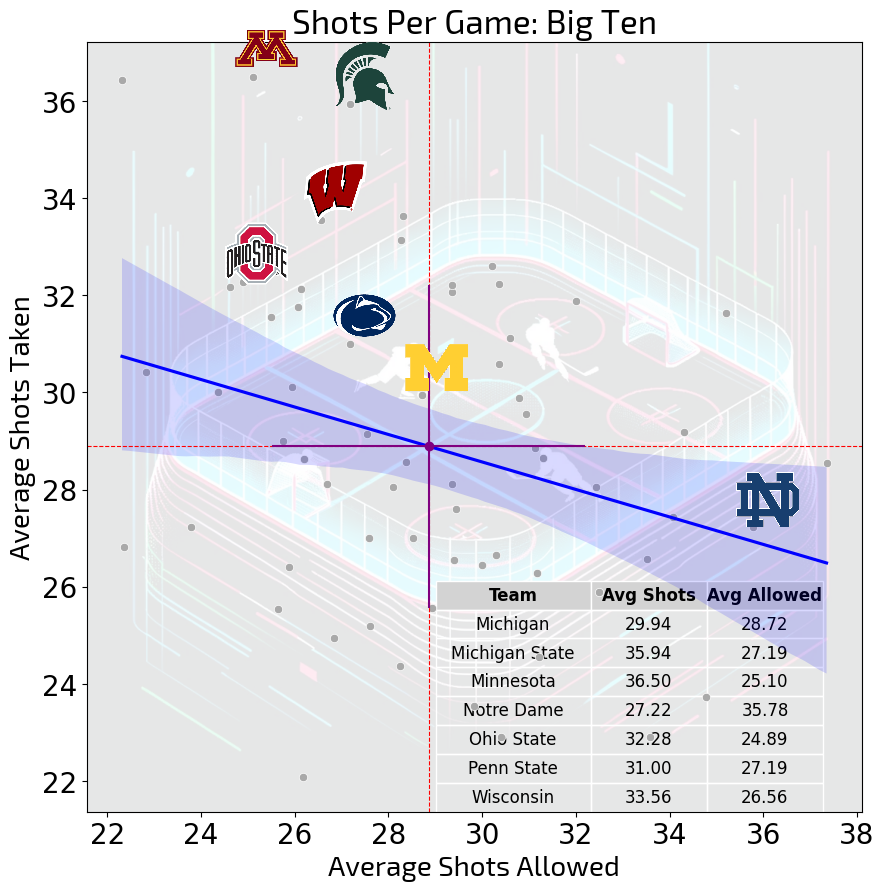

In [63]:
## Call the function
create_avg_shots_plot(group_title, conn, logo_mapping, 
    logo_folder, teams_to_plot,
    )

#### Average Goals Per Game

In [64]:
def create_avg_goals_plot(region_name, teams_to_plot):
    figure_size = (10, 10)  # Optimal size for platforms like Instagram
    
    # SQL query to calculate average goals
    avg_goals_query = """
    WITH UniqueGames AS (
        SELECT DISTINCT * FROM linescore
    )
    SELECT 
        UG1.Team, 
        SUM(UG1.goalsT) AS Total_Goals_Scored, 
        SUM(UG2.goalsT) AS Total_Goals_Allowed,
        COUNT(DISTINCT UG1.Game_ID) AS Games_Played
    FROM 
        UniqueGames UG1
    JOIN 
        UniqueGames UG2 ON UG1.Game_ID = UG2.Game_ID AND UG1.Team != UG2.Team
    GROUP BY 
        UG1.Team;
    """
    
    # Execute the query and store the results in a DataFrame
    avg_goals_df = pd.read_sql(avg_goals_query, conn)

    # Calculate averages of goals scored and allowed
    avg_goals_df['Avg_Goals_Scored'] = avg_goals_df['Total_Goals_Scored'] / avg_goals_df['Games_Played']
    avg_goals_df['Avg_Goals_Allowed'] = avg_goals_df['Total_Goals_Allowed'] / avg_goals_df['Games_Played']

    # Calculate averages and standard deviations
    avg_goals_scored = avg_goals_df['Avg_Goals_Scored'].mean()
    std_goals_scored = avg_goals_df['Avg_Goals_Scored'].std()
    avg_goals_allowed = avg_goals_df['Avg_Goals_Allowed'].mean()
    std_goals_allowed = avg_goals_df['Avg_Goals_Allowed'].std()

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=figure_size)
    sns.scatterplot(data=avg_goals_df, x='Avg_Goals_Allowed', y='Avg_Goals_Scored', color='darkgrey', ax=ax)

    # Add trend line
    sns.regplot(data=avg_goals_df, x='Avg_Goals_Allowed', y='Avg_Goals_Scored', scatter=False, color='blue')

    # Adjust axes
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    new_ymax = ymax + 0.25
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, new_ymax)

    # Add average lines and standard deviation markers
    plt.axhline(y=avg_goals_scored, color='red', linestyle='--', linewidth=0.8)
    plt.axvline(x=avg_goals_allowed, color='red', linestyle='--', linewidth=0.8)
    plt.errorbar(avg_goals_allowed, avg_goals_scored, xerr=std_goals_allowed, 
                 yerr=std_goals_scored, color='purple', fmt='o')

    # Set the background image
    plt.imshow(bg_img, aspect='auto', extent=[xmin, xmax, ymin, new_ymax], zorder=0, alpha=alpha_value)

    # Overlay logos for the teams in the region
    teams_in_region = teams_to_plot  # Use the teams passed as an argument
    add_logos_to_plot(avg_goals_df, 'Avg_Goals_Allowed', 'Avg_Goals_Scored', logo_mapping, logo_folder, ax, teams_in_region)

    # Create table data
    table_data = [['Team', 'Goals For', 'Goals Against']]
    for team in teams_in_region:
        team_data = avg_goals_df[avg_goals_df['Team'] == team]
        if not team_data.empty:
            table_data.append([
                team, 
                f"{team_data['Avg_Goals_Scored'].values[0]:.2f}",
                f"{team_data['Avg_Goals_Allowed'].values[0]:.2f}"
            ])

    # Define the column widths
    col_widths = [0.30, 0.225, 0.225]

    # Add a table at the top right of the plot
    table = plt.table(cellText=table_data, loc='best', 
                      colWidths=col_widths,
                      cellLoc='center', 
                      bbox=[0.45, 0, 0.5, 0.3]
                      )
    
    # Customize the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    for (row, col), cell in table.get_celld().items():
        if row == 0:  # Header row
            cell.set_text_props(weight='bold')
            cell.set_facecolor('lightgrey')
        else:
            cell.set_facecolor('none')
        cell.set_edgecolor('w')

    # Add title and axis labels
    plt.title(f'Goals Per Game: {region_name}', fontdict=font_title_param)
    plt.xlabel('Average Goals Allowed', fontdict=font_label_large_param)
    plt.ylabel('Average Goals Scored', fontdict=font_label_large_param)

    # Save the plot
    plot_path = f'{TEMP_FOLDER}{region_name}_goals_plot.png'
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()


#### Call the AVG Goal/Game Function

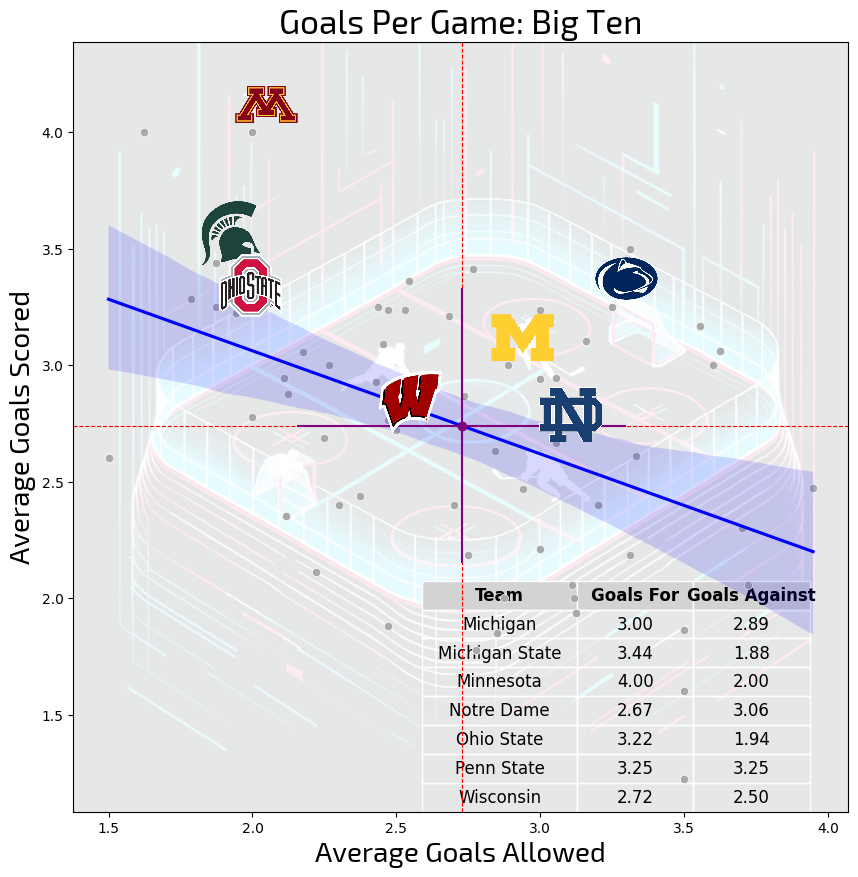

In [65]:
# Call the function
create_avg_goals_plot(group_title, teams_to_plot)

#### Penalty Plot (Scatter)

In [66]:
def create_avg_penalty_plot(group_title, conn, teams_to_plot, show_table=True):
    def add_table_to_plot(ax, avg_penalty_df, teams_to_plot):
        """Adds a table of team penalty stats to the plot."""
        # Create table data
        table_data = [['Team', 'PIM', 'Opp PIM']]
        for team in teams_to_plot:
            team_data = avg_penalty_df[avg_penalty_df['Team'] == team]
            if not team_data.empty:
                table_data.append([
                    team, 
                    f"{team_data['Avg_Penalty_Minutes_For'].values[0]:.1f}",
                    f"{team_data['Avg_Penalty_Minutes_Against'].values[0]:.1f}"
                ])

        # Add table
        table = plt.table(
            cellText=table_data,
            loc='best',
            colWidths=col_widths,  # Assume col_widths is predefined elsewhere
            cellLoc='center',
            bbox=[0.45, 0, 0.5, 0.3]
        )
        
        # Customize the table
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1, 1.5)
        for (row, col), cell in table.get_celld().items():
            if row == 0:  # Header row
                cell.set_text_props(weight='bold')
                cell.set_facecolor('lightgrey')
            else:
                cell.set_facecolor('none')
            cell.set_edgecolor('w')

    # SQL query to calculate the average penalty minutes "for" and "against" each team
    avg_penalty_query = """
    WITH UniqueGames AS (
    SELECT DISTINCT Team, Game_ID, PIM FROM linescore
    )
    SELECT
        a.Team,
        AVG(a.PIM) AS Avg_Penalty_Minutes_For,
        AVG(b.PIM) AS Avg_Penalty_Minutes_Against
    FROM UniqueGames AS a
    JOIN UniqueGames AS b ON a.Game_ID = b.Game_ID AND a.Team != b.Team
    GROUP BY a.Team;
    """
    
    # Execute the query and store the results in a DataFrame
    avg_penalty_df = pd.read_sql(avg_penalty_query, conn)

    # Calculate average and standard deviation for "For" and "Against"
    avg_for = avg_penalty_df['Avg_Penalty_Minutes_For'].mean()
    std_for = avg_penalty_df['Avg_Penalty_Minutes_For'].std()
    avg_against = avg_penalty_df['Avg_Penalty_Minutes_Against'].mean()
    std_against = avg_penalty_df['Avg_Penalty_Minutes_Against'].std()

    # Set figure size
    figure_size = (10, 10)
    fig, ax = plt.subplots(figsize=figure_size)

    # Scatter plot for all teams
    sns.scatterplot(
        data=avg_penalty_df,
        x='Avg_Penalty_Minutes_Against',
        y='Avg_Penalty_Minutes_For',
        color='darkgrey',
        ax=ax
    )

    # Add trend line with standard deviation shading
    sns.regplot(
        data=avg_penalty_df,
        x='Avg_Penalty_Minutes_Against',
        y='Avg_Penalty_Minutes_For',
        scatter=False,
        color='blue',
        ax=ax,
        ci=95,  # Confidence interval for shading (default 95%)
        truncate=False
    )

    # Get axis limits
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # Add average lines and standard deviation markers
    plt.axhline(y=avg_for, color='red', linestyle='--', linewidth=0.8)
    plt.axvline(x=avg_against, color='red', linestyle='--', linewidth=0.8)
    plt.errorbar(avg_against, avg_for, xerr=std_against, yerr=std_for, color='purple', fmt='o')

    # Set the background image
    plt.imshow(bg_img, aspect='auto', extent=[xmin, xmax, ymin, ymax], zorder=0, alpha=alpha_value)

    # Overlay logos for specific teams
    add_logos_to_plot(avg_penalty_df, 'Avg_Penalty_Minutes_Against', 'Avg_Penalty_Minutes_For', logo_mapping, logo_folder, ax, teams_to_plot)

    # Conditionally add the table
    if show_table:
        add_table_to_plot(ax, avg_penalty_df, teams_to_plot)

    # Add title and axis labels
    plt.title(f'Penalty Minutes / Game: {group_title}', fontdict=font_title_param)
    plt.xlabel('Opponent PIMS', fontdict=font_label_param)
    plt.ylabel('Team PIMS', fontdict=font_label_param)

    # Set the tick labels font size and properties
    plt.xticks(fontsize=large_tick_label_size)
    plt.yticks(fontsize=large_tick_label_size)



    # Save the plot
    plot_path = f'{TEMP_FOLDER}{group_title}_penalty_plot.png'
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()


##### Call Function

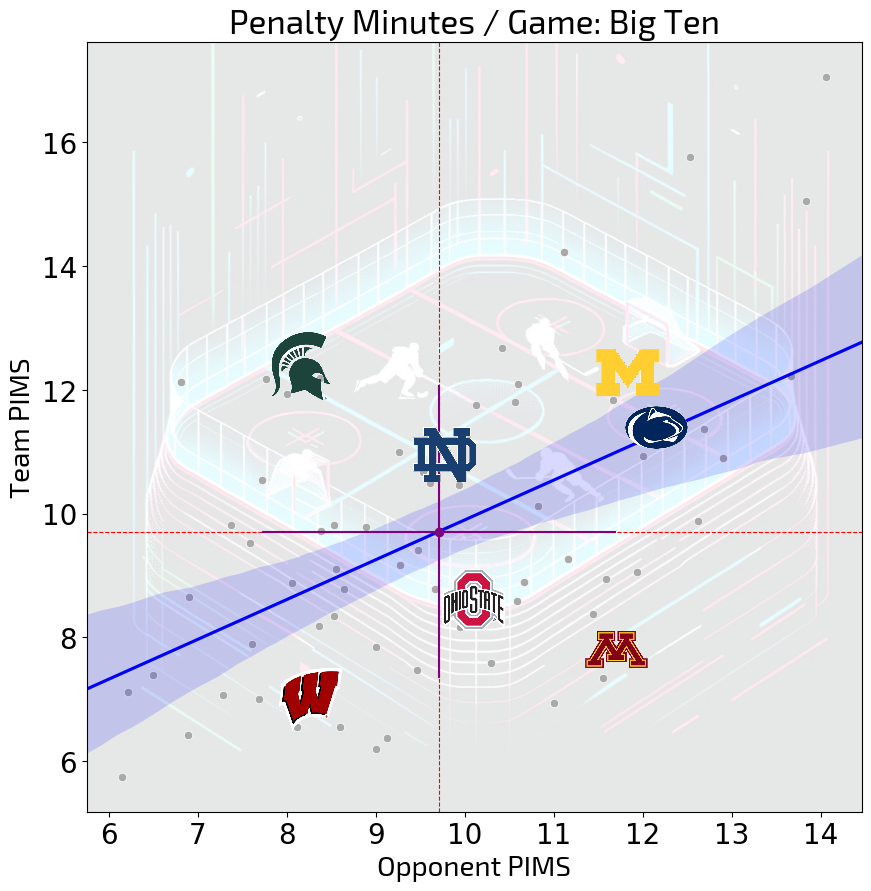

In [67]:
# Create plot with table and standard deviation shading
# create_avg_penalty_plot(group_title, conn, teams_to_plot, show_table=True)

# Create plot without table (standard deviation shading is still displayed)
create_avg_penalty_plot(group_title, conn, teams_to_plot, show_table=False)


#### Special Teams (PP%/PK%)

In [68]:
def create_special_teams_scatter_plot(group_title, conn, teams_to_plot, show_table=True):
    """
    Creates a scatter plot comparing Power Play Percentage (PP%) and Penalty Kill Percentage (PK%) for teams.
    """
    def add_table_to_plot(ax, special_teams_df, teams_to_plot):
        """Adds a table of team special teams stats to the plot."""
        # Create table data
        table_data = [['Team', 'PP%', 'PK%']]
        for team in teams_to_plot:
            team_data = special_teams_df[special_teams_df['Team'] == team]
            if not team_data.empty:
                table_data.append([
                    team,
                    f"{team_data['Team_PP_Percent'].values[0]:.1f}%",
                    f"{team_data['Team_PK_Percent'].values[0]:.1f}%"
                ])

        # Add table
        table = plt.table(
            cellText=table_data,
            loc='best',
            colWidths=[0.2, 0.15, 0.15],  # Adjust column widths
            cellLoc='center',
            bbox=[0.45, 0, 0.5, 0.3]
        )
        
        # Customize the table
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1, 1.5)
        for (row, col), cell in table.get_celld().items():
            if row == 0:  # Header row
                cell.set_text_props(weight='bold')
                cell.set_facecolor('lightgrey')
            else:
                cell.set_facecolor('none')
            cell.set_edgecolor('w')

    # SQL query to calculate Power Play and Penalty Kill stats
    special_teams_query = """
    WITH TeamPowerPlayStats AS (
        SELECT
            Team,
            Game_ID,
            SUM(PPG) AS Total_PPG,
            SUM(PPO) AS Total_PPO,
            (SUM(PPG) * 1.0 / NULLIF(SUM(PPO), 0)) * 100 AS PP_Percentage
        FROM linescore
        GROUP BY Team, Game_ID
    ),
    OpponentPowerPlayStats AS (
        SELECT
            Team AS Opponent,
            Game_ID,
            SUM(PPG) AS Opp_Total_PPG,
            SUM(PPO) AS Opp_Total_PPO,
            (SUM(PPG) * 1.0 / NULLIF(SUM(PPO), 0)) * 100 AS Opp_PP_Percentage
        FROM linescore
        GROUP BY Team, Game_ID
    )
    SELECT
        t.Team,
        AVG(t.PP_Percentage) AS Team_PP_Percent,
        AVG(100 - o.Opp_PP_Percentage) AS Team_PK_Percent
    FROM TeamPowerPlayStats t
    LEFT JOIN OpponentPowerPlayStats o
    ON t.Game_ID = o.Game_ID AND t.Team != o.Opponent
    GROUP BY t.Team;
    """
    
    # Execute the query and store the results in a DataFrame
    special_teams_df = pd.read_sql(special_teams_query, conn)

    # Calculate averages for trend lines
    avg_pp = special_teams_df['Team_PP_Percent'].mean()
    avg_pk = special_teams_df['Team_PK_Percent'].mean()
    std_pp = special_teams_df['Team_PP_Percent'].std()
    std_pk = special_teams_df['Team_PK_Percent'].std()

    # Set figure size
    figure_size = (10, 10)
    fig, ax = plt.subplots(figsize=figure_size)

    # Scatter plot for all teams
    sns.scatterplot(
        data=special_teams_df,
        x='Team_PK_Percent',
        y='Team_PP_Percent',
        color='darkgrey',
        ax=ax
    )

    # Add trend line with standard deviation shading
    sns.regplot(
        data=special_teams_df,
        x='Team_PK_Percent',
        y='Team_PP_Percent',
        scatter=False,
        color='blue',
        ax=ax,
        ci=95,  # Confidence interval for shading
        truncate=False
    )

    # Add average lines and standard deviation markers
    plt.axhline(y=avg_pp, color='red', linestyle='--', linewidth=0.8)
    plt.axvline(x=avg_pk, color='red', linestyle='--', linewidth=0.8)
    plt.errorbar(avg_pk, avg_pp, xerr=std_pk, yerr=std_pp, color='purple', fmt='o')

    # Add the background image
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    plt.imshow(bg_img, aspect='auto', extent=[xmin, xmax, ymin, ymax], zorder=0, alpha=alpha_value)

    

    # Overlay logos for specific teams
    add_logos_to_plot(special_teams_df, 'Team_PK_Percent', 'Team_PP_Percent', logo_mapping, logo_folder, ax, teams_to_plot)

    # Conditionally add the table
    if show_table:
        add_table_to_plot(ax, special_teams_df, teams_to_plot)

    # Add title and axis labels
    plt.title(f'Special Teams: {group_title}', fontdict=font_title_param)
    plt.xlabel('Team PK%', fontdict=font_label_param)
    plt.ylabel('Team PP%', fontdict=font_label_param)

    # Save the plot
    plot_path = f'{TEMP_FOLDER}{group_title}_special_teams_plot.png'
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()


#### Call to Plot Special Teams

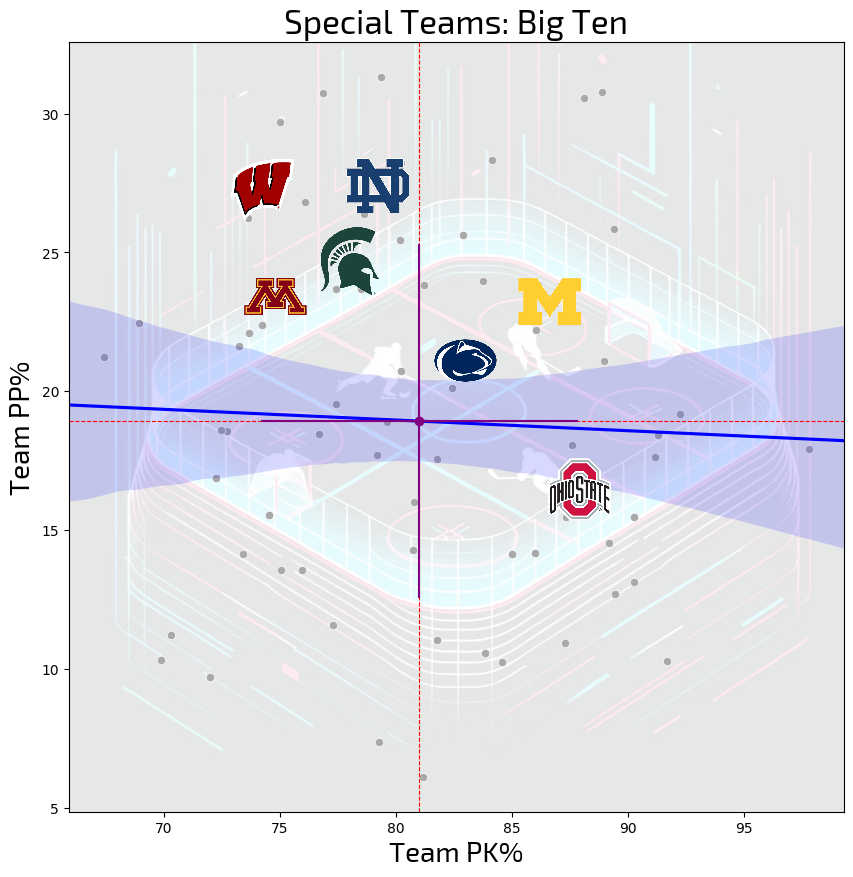

In [69]:
# call the function to create the special teams plot with the current group
create_special_teams_scatter_plot(group_title, conn, 
                    teams_to_plot, show_table=False)


#### Face Off Win Pct.

In [70]:
def create_faceoff_scatter_plot(group_title, conn, teams_to_plot, show_table=True):
    """
    Creates a scatter plot comparing faceoff win percentage for teams and their opponents.
    """
    def add_table_to_plot(ax, faceoff_df, teams_to_plot):
        """Adds a table of team faceoff stats to the plot."""
        # Create table data
        table_data = [['Team', 'FOW%', 'Opp FOW%']]
        for team in teams_to_plot:
            team_data = faceoff_df[faceoff_df['Team'] == team]
            if not team_data.empty:
                table_data.append([
                    team,
                    f"{team_data['Team_FOW_Percent'].values[0]:.1f}%",
                    f"{team_data['Opp_FOW_Percent'].values[0]:.1f}%"
                ])

        # Add table
        table = plt.table(
            cellText=table_data,
            loc='best',
            colWidths=[0.2, 0.15, 0.15],  # Adjust column widths
            cellLoc='center',
            bbox=[0.45, 0, 0.5, 0.3]
        )
        
        # Customize the table
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1, 1.5)
        for (row, col), cell in table.get_celld().items():
            if row == 0:  # Header row
                cell.set_text_props(weight='bold')
                cell.set_facecolor('lightgrey')
            else:
                cell.set_facecolor('none')
            cell.set_edgecolor('w')

    # SQL query to calculate faceoff stats
    faceoff_query = """
    WITH TeamFaceoffStats AS (
        SELECT
            Team,
            Game_ID,
            SUM(FOW) AS Total_FOW,
            SUM(FOL) AS Total_FOL,
            (SUM(FOW) * 1.0 / (SUM(FOW) + SUM(FOL))) AS FOW_Percentage
        FROM linescore
        GROUP BY Team, Game_ID
    ),
    OpponentFaceoffStats AS (
        SELECT
            Team AS Opponent,
            Game_ID,
            SUM(FOW) AS Opp_Total_FOW,
            SUM(FOL) AS Opp_Total_FOL,
            (SUM(FOW) * 1.0 / (SUM(FOW) + SUM(FOL))) AS Opp_FOW_Percentage
        FROM linescore
        GROUP BY Team, Game_ID
    )
    SELECT
        t.Team,
        AVG(t.FOW_Percentage) AS Team_FOW_Percent,
        AVG(o.Opp_FOW_Percentage) AS Opp_FOW_Percent
    FROM TeamFaceoffStats t
    LEFT JOIN OpponentFaceoffStats o
    ON t.Game_ID = o.Game_ID AND t.Team != o.Opponent
    GROUP BY t.Team;
    """
    
    # Execute the query and store the results in a DataFrame
    faceoff_df = pd.read_sql(faceoff_query, conn)

    # Calculate averages for trend lines
    avg_team = faceoff_df['Team_FOW_Percent'].mean()
    avg_opp = faceoff_df['Opp_FOW_Percent'].mean()
    std_team = faceoff_df['Team_FOW_Percent'].std()
    std_opp = faceoff_df['Opp_FOW_Percent'].std()

    # Set figure size
    figure_size = (10, 10)
    fig, ax = plt.subplots(figsize=figure_size)

    # Scatter plot for all teams
    sns.scatterplot(
        data=faceoff_df,
        x='Opp_FOW_Percent',
        y='Team_FOW_Percent',
        color='darkgrey',
        ax=ax
    )

    # Add trend line with standard deviation shading
    sns.regplot(
        data=faceoff_df,
        x='Opp_FOW_Percent',
        y='Team_FOW_Percent',
        scatter=False,
        color='blue',
        ax=ax,
        ci=95,  # Confidence interval for shading
        truncate=False
    )

    # Add average lines and standard deviation markers
    plt.axhline(y=avg_team, color='red', linestyle='--', linewidth=0.8)
    plt.axvline(x=avg_opp, color='red', linestyle='--', linewidth=0.8)
    plt.errorbar(avg_opp, avg_team, xerr=std_opp, yerr=std_team, color='purple', fmt='o')

    # Overlay logos for specific teams
    add_logos_to_plot(faceoff_df, 'Opp_FOW_Percent', 'Team_FOW_Percent', logo_mapping, logo_folder, ax, teams_to_plot)

    # Conditionally add the table
    if show_table:
        add_table_to_plot(ax, faceoff_df, teams_to_plot)

    # Add title and axis labels
    plt.title(f'Faceoff Win Percentage Comparison: {group_title}', fontdict=font_title_param)
    plt.xlabel('Opponent FOW%', fontdict=font_label_param)
    plt.ylabel('Team FOW%', fontdict=font_label_param)

    # Save the plot
    plot_path = f'{TEMP_FOLDER}{group_title}_faceoff_plot.png'
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()


#### Output Face Off Plot
- Useless, not a scatter plot, just need a linear plot

In [71]:
# create_faceoff_scatter_plot(
#     group_title=group_title,
#     conn=conn,
#     teams_to_plot=teams_to_plot,
#     show_table=False
# )


#### Penalty Box Occupancy by Game Phase
- def need to check the y range for each sub plot to make sure they are normalized

##### Functions

###### Logo and Margin Sizing

In [72]:
def calculate_dynamic_figure_size(teams_to_plot, base_figure_size):
    """
    Calculates dynamic figure size based on the number of teams.
    
    Parameters:
    - teams_to_plot (list): List of teams to be plotted.
    - base_figure_size (tuple): The base (width, height) figure size.

    Returns:
    - dynamic_figure_size (tuple): Adjusted (width, height) figure size.
    """
    width, base_height = base_figure_size
    num_teams = len(teams_to_plot)
    if num_teams <= 4:
        return base_figure_size  # Use the base size for small groups
    else:
        additional_height = max(0, (num_teams - 4)) * 1  # 1 inch per extra team
        return (width, base_height + additional_height)


def add_logo_left_margin(ax, team, logo_mapping, logo_folder, zoom=0.15, x_margin=0.15, y_offset=0):
    """
    Adds a team logo to the left margin of the plot, replacing text labels.

    Parameters:
    - ax: The matplotlib axis object where the logo will be added.
    - team (str): Team name.
    - logo_mapping (dict): Dictionary mapping team names to logo file names.
    - logo_folder (str): Path to the folder containing logo images.
    - zoom (float): Scaling factor for the logo.
    - x_margin (float): Proportion of the figure width reserved for the margin.
    - y_offset (float): Vertical offset for fine-tuning the position (in axes fraction).
    """
    logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
    if logo_path:
        try:
            logo_img = plt.imread(logo_path)
            # Determine vertical center in axes coordinates
            y_mid = 0.5 + y_offset
            # Position in the left margin (relative to axes)
            x_pos = -x_margin  # Left of the plot area
            imagebox = OffsetImage(logo_img, zoom=zoom)
            ab = AnnotationBbox(
                imagebox,
                (x_pos, y_mid),  # Apply x-margin and vertical centering
                frameon=False,
                xycoords='axes fraction',
                boxcoords='axes fraction',
                pad=0
            )
            ax.add_artist(ab)
        except Exception as e:
            print(f"Error adding logo for {team}: {e}")


def calculate_logo_zoom(num_teams):
    """
    Dynamically calculates the zoom factor for team logos based on the number of teams.
    
    Parameters:
    - num_teams (int): The number of teams in the list.
    
    Returns:
    - zoom (float): The calculated zoom factor.
    """
    # Define the known data points for team count and zoom
    team_counts = [4, 7, 11]  # Known team counts
    zoom_values = [0.45, 0.3, 0.25]  # Corresponding zoom levels
    
    if num_teams <= team_counts[0]:
        return zoom_values[0]  # Use maximum zoom for small groups
    elif num_teams >= team_counts[-1]:
        return zoom_values[-1]  # Use minimum zoom for large groups
    else:
        # Linearly interpolate between the known points
        slope = (zoom_values[2] - zoom_values[1]) / (team_counts[2] - team_counts[1])
        return zoom_values[1] + slope * (num_teams - team_counts[1])

def calculate_x_margin(zoom, base_zoom=0.3, base_margin=0.075):
    """
    Dynamically calculates the x_margin value based on the zoom factor.
    
    Parameters:
    - zoom (float): The zoom factor for the logo.
    - base_zoom (float): The baseline zoom factor (default is 0.3).
    - base_margin (float): The baseline x_margin for the baseline zoom factor (default is 0.075).
    
    Returns:
    - x_margin (float): The calculated x_margin value.
    """
    # Scale x_margin proportionally to the zoom factor
    return base_margin * (zoom / base_zoom)


def calculate_penalty_bin_max(penalty_data, teams_to_plot, bins=65):
    penalty_data['Start_Time'] = penalty_data.apply(convert_to_continuous_time, axis=1)
    penalty_data['End_Time'] = penalty_data['Start_Time'] + penalty_data['Pen_Length']
    penalty_data = penalty_data[penalty_data['Pen_Length'].isin([2, 5])]

    time_points = np.linspace(0, 65, 65 * 60)
    global_bin_max = 0

    for team in teams_to_plot:
        team_data = penalty_data[penalty_data['Team'] == team]
        opponent_data = penalty_data[
            (penalty_data['Game_ID'].isin(team_data['Game_ID'].unique())) & (penalty_data['Team'] != team)
        ]

        team_penalty_count = np.zeros_like(time_points)
        opponent_penalty_count = np.zeros_like(time_points)

        for _, row in team_data.iterrows():
            start_idx = np.searchsorted(time_points, row['Start_Time'])
            end_idx = min(len(time_points), np.searchsorted(time_points, row['End_Time']))
            team_penalty_count[start_idx:end_idx] += 1

        for _, row in opponent_data.iterrows():
            start_idx = np.searchsorted(time_points, row['Start_Time'])
            end_idx = min(len(time_points), np.searchsorted(time_points, row['End_Time']))
            opponent_penalty_count[start_idx:end_idx] += 1

        combined_penalty_count = team_penalty_count + opponent_penalty_count
        max_bin_value = combined_penalty_count.max()
        global_bin_max = max(global_bin_max, max_bin_value)

        # add an additional buffer for better visualization - guess and hope it works
        # global_bin_max = global_bin_max * 1.65
        global_bin_max = global_bin_max * 2

    return global_bin_max


In [73]:
# call the data from the db
def extract_penalty_summary(conn):
    """
    Extracts and preprocesses the penalty summary data from the database.
    """
    query = """
    WITH UniquePenalties AS (
        SELECT DISTINCT * FROM penalty_summary
    )
    SELECT * FROM UniquePenalties;
    """
    penalty_df = pd.read_sql(query, conn)
    penalty_df['Pen_Length'] = penalty_df['Pen_Length'].astype('int')
    return penalty_df

# convert string time to continuous time
def convert_to_continuous_time(row):
    """
    Converts period-based time to a continuous format (0-65 minutes).
    """
    period_offsets = {'1st Period': 0, '2nd Period': 20, '3rd Period': 40, 'OT': 60}
    minutes, seconds = map(int, row['Time'].split(':'))
    offset = period_offsets.get(row['Period'], 0)
    return offset + minutes + seconds / 60.0

# define shading for periods, colors, ect
def add_period_shading(ax):
    """
    Adds shading for periods to the plot background.
    """
    ax.axvspan(0, 20, facecolor='yellow', alpha=0.5, zorder=0)
    ax.axvspan(20, 40, facecolor='lightgrey', alpha=0.75, zorder=0)
    ax.axvspan(40, 60, facecolor='yellow', alpha=0.5, zorder=0)
    ax.axvspan(60, 65, facecolor='lightgrey', alpha=0.75, zorder=0)

# plot the team penalties - helper function - legacy code - IN USE
def plot_team_penalties(ax, team, penalty_data, color_mapping, logo_mapping, logo_folder, bins=65):
    """
    Plots penalty box occupancy over time for a specific team and its opponents.
    """
    penalty_data['Start_Time'] = penalty_data.apply(convert_to_continuous_time, axis=1)
    penalty_data['End_Time'] = penalty_data['Start_Time'] + penalty_data['Pen_Length']
    penalty_data = penalty_data[penalty_data['Pen_Length'].isin([2, 5])]

    # Filter data for team and opponents
    team_data = penalty_data[penalty_data['Team'] == team]
    opponent_data = penalty_data[penalty_data['Game_ID'].isin(team_data['Game_ID'].unique()) & (penalty_data['Team'] != team)]

    time_points = np.linspace(0, 65, 65 * 60)
    team_penalty_count = np.zeros_like(time_points)
    opponent_penalty_count = np.zeros_like(time_points)

    # Populate counts
    for _, row in team_data.iterrows():
        start_idx = np.searchsorted(time_points, row['Start_Time'])
        end_idx = np.searchsorted(time_points, row['End_Time'])
        team_penalty_count[start_idx:end_idx] += 1

    for _, row in opponent_data.iterrows():
        start_idx = np.searchsorted(time_points, row['Start_Time'])
        end_idx = np.searchsorted(time_points, row['End_Time'])
        opponent_penalty_count[start_idx:end_idx] += 1

    color = color_mapping.get(team, ['#000000'])[0]  # Default to black if team not found
    ax.hist(time_points, bins=bins, weights=team_penalty_count, color=color, alpha=0.9, edgecolor='black', label=f'{team} Penalties')
    ax.hist(time_points, bins=bins, weights=opponent_penalty_count, color='grey', alpha=0.5, edgecolor='black', label='Opponent Penalties')

    # Set x-axis ticks and labels
    ax.set_xticks([10, 30, 50, 62.5])
    ax.set_xticklabels(['1st Period', '2nd Period', '3rd Period', 'OT'], **font_tick_param)

    
    # Set labels and title
    ax.set_ylabel(team, **font_label_param)
    ax.grid(False)
    add_period_shading(ax)

    # Remove Y-axis ticks
    ax.set_yticks([])

# # define the function to output the image, set parameters, and show the plot

def create_penalty_summary_plot(region_name, conn, teams_to_plot, color_mapping, logo_mapping, logo_folder, base_figure_size, use_logos_as_y_labels=False):
    """
    Creates a summary plot for penalty box occupancy over game time for a set of teams.

    Parameters:
    - region_name (str): Title of the region or group being plotted.
    - conn: Database connection object.
    - teams_to_plot (list): List of teams to be plotted.
    - color_mapping (dict): Dictionary of team colors.
    - logo_mapping (dict): Dictionary of team logos.
    - logo_folder (str): Path to the folder containing logos.
    - base_figure_size (tuple): Base figure size (width, height).
    - use_logos_as_y_labels (bool): Whether to use team logos instead of text for y-axis labels.
    """
    # Dynamically calculate the figure size
    figure_size = calculate_dynamic_figure_size(teams_to_plot, base_figure_size)

    # Extract penalty data
    penalty_data = extract_penalty_summary(conn)

    # Calculate the global maximum penalty box occupancy
    global_bin_max = calculate_penalty_bin_max(penalty_data, teams_to_plot)

    # Set up the figure with dynamic size
    fig, axes = plt.subplots(len(teams_to_plot), 1, figsize=figure_size, sharex=True)
    if len(teams_to_plot) == 1:
        axes = [axes]  # Ensure axes is iterable

    # Adjust margin for logos
    left_margin = 0.25 if use_logos_as_y_labels else 0.1  # Adjust margin dynamically
    for ax in axes:
        pos = ax.get_position()
        ax.set_position([pos.x0 + left_margin, pos.y0, pos.width - left_margin, pos.height])  # Shift axes

    # Plot each team's penalties
    for ax, team in zip(axes, teams_to_plot):
        penalty_data_team = penalty_data[penalty_data['Team'] == team]
        if penalty_data_team.empty:
            continue  # Skip if no data for the team

        # Plot team penalties
        plot_team_penalties(ax, team, penalty_data, color_mapping, logo_mapping, logo_folder)

        # Set consistent y-axis limits using the global maximum
        # ax.set_ylim(0, global_bin_max + 1)  # Add a small buffer for visualization
        ax.set_ylim(0, global_bin_max/4 + 1)  # Add a small buffer for visualization

        # Use team logo or name for y-axis label
        if use_logos_as_y_labels:
            ax.set_ylabel('')
            add_logo_left_margin(
                ax=ax,
                team=team,
                logo_mapping=logo_mapping,
                logo_folder=logo_folder,
                zoom=calculate_logo_zoom(len(teams_to_plot)),
                x_margin=calculate_x_margin(calculate_logo_zoom(len(teams_to_plot))),
                y_offset=-0.05,
            )
        else:
            ax.set_ylabel(team, **font_label_param)

        # Remove subplot borders
        for spine in ax.spines.values():
            spine.set_visible(False)

    # Adjust layout for spacing between subplots
    plt.subplots_adjust(hspace=0.05)  # Fine-tune vertical spacing

    # Apply shared font parameters for the title
    fig.suptitle(f'Penalty Box Occupancy Over Game Time: {region_name}', **font_title_param)

    # Add x-axis label to the last subplot
    axes[-1].set_xlabel('Game Time (Minutes)', **font_label_param)

        # add text to bottom of plot with source
    fig.text(0.5, -0.015, f'Team color represents number of team penalties. Gray shading represents opponent penalties\nData Source: College Hockey News. Includes all games through {last_game_date}', ha='center',
     fontsize=12,
     color='black',
     # Center the text horizontally
        horizontalalignment='center',
        verticalalignment='center'
        )

    # Adjust layout
    plt.tight_layout()
    plt.show()


###### Test Dictionaries

In [74]:
# Create four team dictionary for testing
# teams_to_plot = ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame']

# 15 team dictionary for testing
# teams_to_plot = ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin', 'Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 'St Cloud State']




###### End

### Output Penalty Box Plot

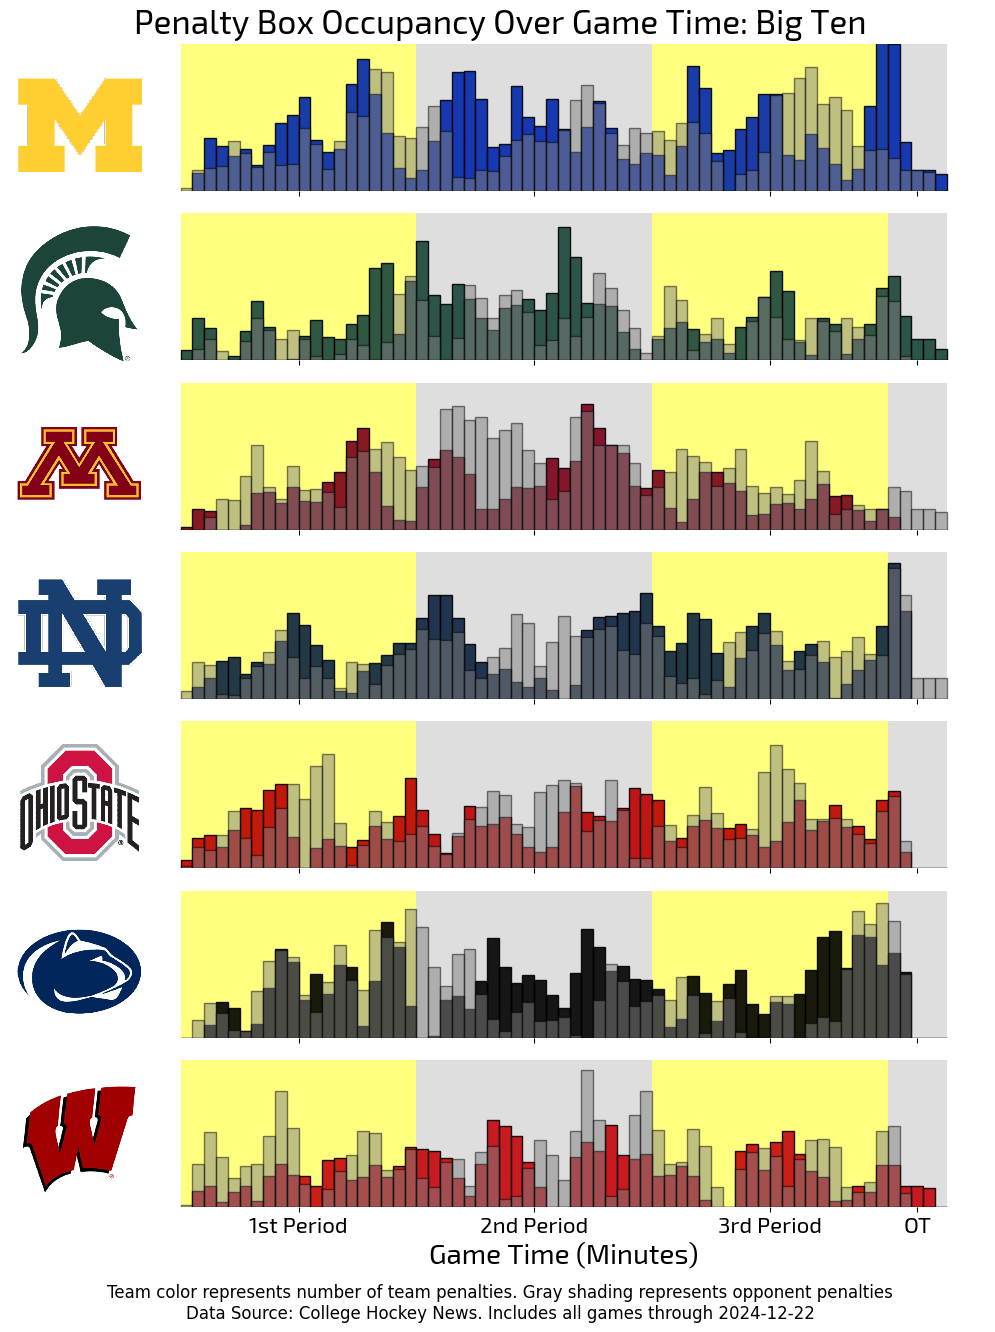

In [75]:
# region_name = "Hockey East"
# region_name = "Big Ten"
# region_name = "Atlantic"

# teams_to_plot = conference_teams_mens['Hockey East']
# teams_to_plot = conference_teams_mens['Big Ten']
# teams_to_plot = conference_teams_mens['Atlantic']


# Call the plot function with dynamic sizing
create_penalty_summary_plot(
    region_name=group_title,  # Title of the region or group
    conn=conn,  # Active database connection
    teams_to_plot=teams_to_plot,
    color_mapping=color_mapping,
    logo_mapping=logo_mapping,
    logo_folder=logo_folder,  # Path to logo files
    base_figure_size=figure_size,
    use_logos_as_y_labels=True  # Use logos instead of text for y-axis labels  # Reference global figure size
)


### Goal Chart Over Time 
- Need to change code so the y range is the same for each team
- defeats purpose if the scale means nothing

In [76]:
# Define Period Shade Function
def add_period_shading(ax):
    """
    Adds shading to highlight game periods.
    """
    # Shade 1st period (0-20 minutes) and 3rd period (40-60 minutes) in light grey
    ax.axvspan(0, 20, facecolor='lightyellow', alpha=0.5, zorder=0)
    ax.axvspan(40, 60, facecolor='lightyellow', alpha=0.5, zorder=0)
    # Shade 2nd period (20-40 minutes) and OT (60-65 minutes) in light yellow
    ax.axvspan(20, 40, facecolor='lightgrey', alpha=0.5, zorder=0)
    ax.axvspan(60, 65, facecolor='lightgrey', alpha=0.5, zorder=0)


In [77]:
## SQL query to fetch
def extract_goal_summary(conn):
    """
    Extracts and preprocesses the goal summary data from the database.
    """
    query = """
    WITH UniqueGoals AS (
        SELECT DISTINCT Game_ID, Team, Period, Time, PP
        FROM scoring_summary
    )
    SELECT * FROM UniqueGoals;
    """
    goal_df = pd.read_sql(query, conn)
    return goal_df

# Convert string time to continuous time
def convert_to_continuous_time(row):
    """
    Converts period-based time to a continuous format (0-65 minutes).
    """
    period_offsets = {'1st Period': 0, '2nd Period': 20, '3rd Period': 40, 'OT': 60}
    minutes, seconds = map(int, row['Time'].split(':'))
    offset = period_offsets.get(row['Period'], 0)
    return offset + minutes + seconds / 60.0


def calculate_bin_max(goal_data, teams_to_plot, bin_size=1):
    """
    Calculate the maximum number of goals scored in any specific bin across all teams.

    Parameters:
    - goal_data (DataFrame): Processed goal data.
    - teams_to_plot (list): List of teams to be plotted.
    - bin_size (float): Size of each time bin in minutes.

    Returns:
    - int: Maximum number of goals scored in a single bin.
    """
    total_duration = 65  # Total game time in minutes
    bins = int(total_duration / bin_size)  # Number of bins
    time_points = np.linspace(0, total_duration, bins + 1)  # Define bin edges

    global_bin_max = 0

    for team in teams_to_plot:
        # Filter data for the team
        team_data = goal_data[goal_data['Team'] == team]
        # Filter data for opponents in the same games
        opponent_game_ids = team_data['Game_ID'].unique()
        opponent_data = goal_data[(goal_data['Game_ID'].isin(opponent_game_ids)) & (goal_data['Team'] != team)]

        # Initialize bin counts
        team_goal_count = np.zeros_like(time_points[:-1])
        opponent_goal_count = np.zeros_like(time_points[:-1])

        # Populate counts for the team
        for _, row in team_data.iterrows():
            goal_idx = np.searchsorted(time_points, row['Continuous_Time']) - 1
            if 0 <= goal_idx < len(team_goal_count):
                team_goal_count[goal_idx] += 1

        # Populate counts for opponents
        for _, row in opponent_data.iterrows():
            goal_idx = np.searchsorted(time_points, row['Continuous_Time']) - 1
            if 0 <= goal_idx < len(opponent_goal_count):
                opponent_goal_count[goal_idx] += 1

        # Find the maximum for this team and update the global max
        max_bin_goals = max(team_goal_count.max(), opponent_goal_count.max())
        global_bin_max = max(global_bin_max, max_bin_goals)

    return global_bin_max


In [78]:
# Plot team goals - helper function
def plot_team_goals(ax, team, goal_data, color_mapping, logo_mapping, logo_folder, bin_size=1):
    """
    Plots goal occurrences over game time for a specific team and their opponents.

    Parameters:
    - ax: The matplotlib axis to plot on.
    - team (str): Team name.
    - goal_data (DataFrame): Processed goal data.
    - color_mapping (dict): Dictionary mapping team names to colors.
    - logo_mapping (dict): Dictionary mapping team names to logos.
    - logo_folder (str): Path to the folder containing team logos.
    - bin_size (float): Size of each time bin in minutes (default is 1 minute).
    """
    # Filter data for the team
    team_data = goal_data[goal_data['Team'] == team]
    # Filter data for opponents in the same games
    opponent_game_ids = team_data['Game_ID'].unique()
    opponent_data = goal_data[(goal_data['Game_ID'].isin(opponent_game_ids)) & (goal_data['Team'] != team)]

    # Calculate the number of bins dynamically
    total_duration = 65  # Total game time in minutes
    bins = int(total_duration / bin_size)  # Number of bins
    time_points = np.linspace(0, total_duration, bins + 1)  # Define bin edges

    team_goal_count = np.zeros_like(time_points[:-1])
    opponent_goal_count = np.zeros_like(time_points[:-1])

    # Populate counts for the team
    for _, row in team_data.iterrows():
        goal_idx = np.searchsorted(time_points, row['Continuous_Time']) - 1
        if 0 <= goal_idx < len(team_goal_count):
            team_goal_count[goal_idx] += 1

    # Populate counts for opponents
    for _, row in opponent_data.iterrows():
        goal_idx = np.searchsorted(time_points, row['Continuous_Time']) - 1
        if 0 <= goal_idx < len(opponent_goal_count):
            opponent_goal_count[goal_idx] += 1

    # Plot team goals
    color = color_mapping.get(team, ['#000000'])[0]  # Default to black if team not found
    ax.bar(
        time_points[:-1], team_goal_count, width=bin_size, color=color,
        alpha=0.9, edgecolor='black', label=f'{team} Goals', align='edge'
    )

    # Plot opponent goals in grey
    ax.bar(
        time_points[:-1], opponent_goal_count, width=bin_size, color='grey',
        alpha=0.5, edgecolor='black', label='Opponent Goals', align='edge'
    )

    # Add period shading
    add_period_shading(ax)

    # Set x-axis ticks and labels
    ax.set_xticks([10, 30, 50, 62.5])
    ax.set_xticklabels(['1st Period', '2nd Period', '3rd Period', 'OT'])

    # Add labels
    ax.set_ylabel(team, **font_label_param)
    ax.grid(True)

In [79]:
# Define the function to create the goal summary plot with consistent y-axis limits
def create_goal_summary_plot(region_name, conn, teams_to_plot, color_mapping, logo_mapping, logo_folder, base_figure_size, use_logos_as_y_labels=False, bin_size=1):
    """
    Creates a summary plot for goal occurrences over game time for a set of teams.

    Parameters:
    - region_name (str): Title of the region or group being plotted.
    - conn: Database connection object.
    - teams_to_plot (list): List of teams to be plotted.
    - color_mapping (dict): Dictionary of team colors.
    - logo_mapping (dict): Dictionary of team logos.
    - logo_folder (str): Path to the folder containing logos.
    - base_figure_size (tuple): Base figure size (width, height).
    - use_logos_as_y_labels (bool): Whether to use team logos instead of text for y-axis labels.
    - bin_size (float): Size of each time bin in minutes.
    """
    # Dynamically calculate the figure size
    figure_size = calculate_dynamic_figure_size(teams_to_plot, base_figure_size)

    # Extract goal data
    goal_data = extract_goal_summary(conn)

    # Create the Continuous Time column
    goal_data['Continuous_Time'] = goal_data.apply(convert_to_continuous_time, axis=1)

    # Calculate the global maximum number of goals in any bin
    global_bin_max = calculate_bin_max(goal_data, teams_to_plot, bin_size=bin_size)

    # Set up the figure with dynamic size
    fig, axes = plt.subplots(len(teams_to_plot), 1, figsize=figure_size, sharex=True)
    if len(teams_to_plot) == 1:
        axes = [axes]  # Ensure axes is iterable

    # Adjust margin for logos
    left_margin = 0.25 if use_logos_as_y_labels else 0.1  # Adjust margin dynamically
    for ax in axes:
        pos = ax.get_position()
        ax.set_position([pos.x0 + left_margin, pos.y0, pos.width - left_margin, pos.height])  # Shift axes

    # Plot each team's goals
    for ax, team in zip(axes, teams_to_plot):
        plot_team_goals(ax, team, goal_data, color_mapping, logo_mapping, logo_folder, bin_size=bin_size)

        # Set consistent y-axis limits using the global bin maximum
        ax.set_ylim(0, global_bin_max + 1)  # Add a small buffer for better visualization

    # Adjust layout for spacing between subplots
    plt.subplots_adjust(hspace=0.05)  # Fine-tune vertical spacing

    # Apply shared font parameters for the title
    fig.suptitle(f'Goal Occurrences Over Game Time: {region_name}', **font_title_param)

    # Add x-axis label to the last subplot
    axes[-1].set_xlabel('Game Time (Minutes)', **font_label_param)

        # add text to bottom of plot with source
    fig.text(0.5, -0.015, f'Team color represents number of goals scored. Gray shading represents goals allowed\nData Source: College Hockey News. Includes all games through {last_game_date}', ha='center',
     fontsize=12,
     color='black',
     # Center the text horizontally
        horizontalalignment='center',
        verticalalignment='center'
        )

    # Adjust layout
    plt.tight_layout()
    plt.show()


### Output Goal over game time bar plot

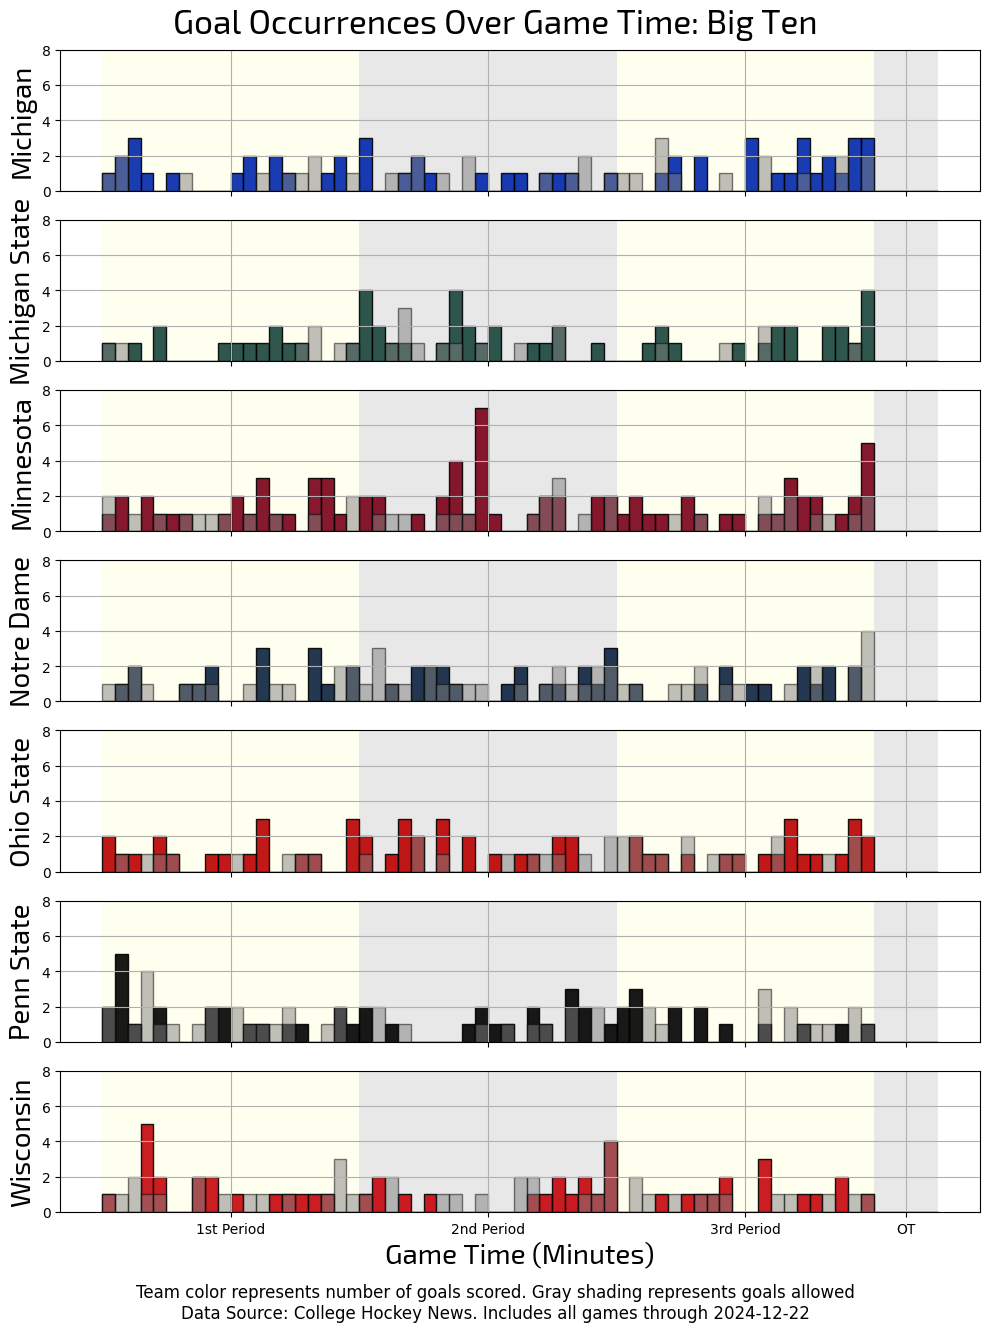

In [80]:
# region_name = "Big Ten Conference"
# teams_to_plot = conference_teams_mens['Big Ten']
# teams_to_plot = conference_teams_mens['Hockey East']

# Plot goals with 2.5-minute bins
create_goal_summary_plot(
    region_name=group_title,
    conn=conn,
    teams_to_plot=teams_to_plot,
    color_mapping=color_mapping,
    logo_mapping=logo_mapping,
    logo_folder=logo_folder,
    base_figure_size=figure_size,
    use_logos_as_y_labels=True,
    # bin_size=10
)

## Cumlative Goal Filled Line Chart

In [81]:
# This version just works for cumlative goals
# Function to calculate the global maximum cumulative goals
def calculate_global_max(goal_data, teams_to_plot, bins=65):
    """
    Calculate the global maximum cumulative goals across all teams.

    Parameters:
    - goal_data (DataFrame): Processed goal data.
    - teams_to_plot (list): List of teams to be plotted.
    - bins (int): Number of bins for dividing the game time.

    Returns:
    - int: Global maximum cumulative goals.
    """
    total_duration = 65  # Total game time in minutes
    time_points = np.linspace(0, total_duration, bins + 1)
    global_max = 0

    for team in teams_to_plot:
        # Filter data for the team
        team_data = goal_data[goal_data['Team'] == team]
        # Filter data for opponents in the same games
        opponent_game_ids = team_data['Game_ID'].unique()
        opponent_data = goal_data[(goal_data['Game_ID'].isin(opponent_game_ids)) & (goal_data['Team'] != team)]

        # Calculate cumulative goals for the team
        team_cumulative_goals = np.zeros_like(time_points)
        for _, row in team_data.iterrows():
            goal_idx = np.searchsorted(time_points, row['Continuous_Time'])
            team_cumulative_goals[goal_idx:] += 1

        # Calculate cumulative goals for opponents
        opponent_cumulative_goals = np.zeros_like(time_points)
        for _, row in opponent_data.iterrows():
            goal_idx = np.searchsorted(time_points, row['Continuous_Time'])
            opponent_cumulative_goals[goal_idx:] += 1

        # Update global max
        global_max = max(global_max, team_cumulative_goals.max(), opponent_cumulative_goals.max())

    return global_max


##### Cumlative Goal Plotting Function Guts

In [82]:
def plot_team_cumulative_goals(ax, team, goal_data, color_mapping, bins=65):
    """
    Plots cumulative goals over game time for a specific team and their opponents.

    Parameters:
    - ax: The matplotlib axis to plot on.
    - team (str): Team name.
    - goal_data (DataFrame): Processed goal data.
    - color_mapping (dict): Dictionary mapping team names to colors.
    - bins (int): Number of bins for dividing the game time (default is 65 for 1-minute bins).
    """
    # Filter data for the team
    team_data = goal_data[goal_data['Team'] == team]
    # Filter data for opponents in the same games
    opponent_game_ids = team_data['Game_ID'].unique()
    opponent_data = goal_data[(goal_data['Game_ID'].isin(opponent_game_ids)) & (goal_data['Team'] != team)]

    # Create time points and initialize cumulative counts
    total_duration = 65  # Total game time in minutes
    time_points = np.linspace(0, total_duration, bins + 1)
    team_cumulative_goals = np.zeros_like(time_points)
    opponent_cumulative_goals = np.zeros_like(time_points)

    # Populate cumulative counts for the team
    for _, row in team_data.iterrows():
        goal_idx = np.searchsorted(time_points, row['Continuous_Time'])
        team_cumulative_goals[goal_idx:] += 1

    # Populate cumulative counts for opponents
    for _, row in opponent_data.iterrows():
        goal_idx = np.searchsorted(time_points, row['Continuous_Time'])
        opponent_cumulative_goals[goal_idx:] += 1

    # Calculate average goals scored and allowed at the end of each period
    period_end_times = [20, 40, 60]  # End times for 1st, 2nd, and 3rd periods
    avg_team_goals = []
    avg_opponent_goals = []

    for period_end in period_end_times:
        period_idx = np.searchsorted(time_points, period_end)
        avg_team_goals.append(team_cumulative_goals[period_idx] / len(team_data['Game_ID'].unique()))
        avg_opponent_goals.append(opponent_cumulative_goals[period_idx] / len(opponent_data['Game_ID'].unique()))

    # Plot team cumulative goals as a filled area
    color = color_mapping.get(team, ['#000000'])[0]  # Default to black if team not found
    ax.fill_between(
        time_points, 0, team_cumulative_goals,
        color=color, alpha=0.7, label=f'{team} Goals'
    )

    # Shade the area under the opponent goals line subtly
    ax.fill_between(
        time_points, 0, opponent_cumulative_goals,
        color='grey', alpha=0.2, label='Opponent Goals (Shaded)'
    )

    # Determine the line color for opponent goals
    line_color = np.where(opponent_cumulative_goals > team_cumulative_goals, 'red', 'white')

    # Plot opponent cumulative goals as a dynamic line
    for i in range(1, len(time_points)):
        ax.plot(
            time_points[i-1:i+1], opponent_cumulative_goals[i-1:i+1],
            color=line_color[i], linewidth=1.5, zorder=3  # Ensure it's above the fill, reduced line weight
        )

    # Adjust y-axis limits dynamically
    max_goals = max(team_cumulative_goals.max(), opponent_cumulative_goals.max())
    ax.set_ylim(0, max_goals + 10)  # Add a small buffer for better visualization

    # Add period shading
    add_period_shading(ax)

    # Set x-axis ticks and labels
    ax.set_xticks([10, 30, 50, 62.5])
    ax.set_xticklabels(['1st Period', '2nd Period', '3rd Period', 'OT'])

    # Add annotations for average team goals and goals allowed at the end of each period
    for i, period_end in enumerate(period_end_times):
        avg_text = f"Avg After {i+1}\n{avg_team_goals[i]:.2f} - {avg_opponent_goals[i]:.2f}"
        annotation_x = period_end - 2  # Adjust closer to the right edge of the period
        annotation_y = max_goals + 2  # Position at the top of the plot
        ax.annotate(
            avg_text,
            (annotation_x, annotation_y),
            textcoords="offset points",
            xytext=(-10, 0),
            ha='center', fontsize=10, color='blue',  # Text color and font size
            bbox=dict(boxstyle="round4,pad=0.5", edgecolor="red", facecolor="yellow", alpha=0.85),  # Box customization
            arrowprops=dict(arrowstyle="->", color="green", lw=2, shrinkA=0, shrinkB=0)  # Arrow customization
        )

    # Add labels
    ax.set_ylabel(team, **font_label_param)

    # Adjust grid lines to be more subtle
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)


In [83]:
# def plot_team_cumulative_goals(ax, team, goal_data, color_mapping, bins=65):
#     """
#     Plots cumulative goals over game time for a specific team and their opponents.

#     Parameters:
#     - ax: The matplotlib axis to plot on.
#     - team (str): Team name.
#     - goal_data (DataFrame): Processed goal data.
#     - color_mapping (dict): Dictionary mapping team names to colors.
#     - bins (int): Number of bins for dividing the game time (default is 65 for 1-minute bins).
#     """
#     # Filter data for the team
#     team_data = goal_data[goal_data['Team'] == team]
#     # Filter data for opponents in the same games
#     opponent_game_ids = team_data['Game_ID'].unique()
#     opponent_data = goal_data[(goal_data['Game_ID'].isin(opponent_game_ids)) & (goal_data['Team'] != team)]

#     # Create time points and initialize cumulative counts
#     total_duration = 65  # Total game time in minutes
#     time_points = np.linspace(0, total_duration, bins + 1)
#     team_cumulative_goals = np.zeros_like(time_points)
#     opponent_cumulative_goals = np.zeros_like(time_points)

#     # Populate cumulative counts for the team
#     for _, row in team_data.iterrows():
#         goal_idx = np.searchsorted(time_points, row['Continuous_Time'])
#         team_cumulative_goals[goal_idx:] += 1

#     # Populate cumulative counts for opponents
#     for _, row in opponent_data.iterrows():
#         goal_idx = np.searchsorted(time_points, row['Continuous_Time'])
#         opponent_cumulative_goals[goal_idx:] += 1

#     # Calculate average goals scored and allowed at the end of each period
#     period_end_times = [20, 40, 60]  # End times for 1st, 2nd, and 3rd periods
#     avg_team_goals = []
#     avg_opponent_goals = []

#     for period_end in period_end_times:
#         period_idx = np.searchsorted(time_points, period_end)
#         avg_team_goals.append(team_cumulative_goals[period_idx] / len(team_data['Game_ID'].unique()))
#         avg_opponent_goals.append(opponent_cumulative_goals[period_idx] / len(opponent_data['Game_ID'].unique()))

#     # Plot team cumulative goals as a filled area
#     color = color_mapping.get(team, ['#000000'])[0]  # Default to black if team not found
#     ax.fill_between(
#         time_points, 0, team_cumulative_goals,
#         color=color, alpha=0.7, label=f'{team} Goals'
#     )

#     # Shade the area under the opponent goals line subtly
#     ax.fill_between(
#         time_points, 0, opponent_cumulative_goals,
#         color='lightgrey', alpha=0.25, label='Opponent Goals (Shaded)'
#     )

#     # Determine the line color for opponent goals
#     line_color = np.where(opponent_cumulative_goals > team_cumulative_goals, 'red', 'white')

#     # Plot opponent cumulative goals as a dynamic line
#     for i in range(1, len(time_points)):
#         ax.plot(
#             time_points[i-1:i+1], opponent_cumulative_goals[i-1:i+1],
#             color=line_color[i], linewidth=1.0, zorder=3  # Ensure it's above the fill, reduced line weight
#         )

#     # Adjust y-axis limits dynamically
#     max_goals = max(team_cumulative_goals.max(), opponent_cumulative_goals.max())
#     ax.set_ylim(0, max_goals + 10)  # Add a small buffer for better visualization

#     # Add period shading
#     add_period_shading(ax)

#     # Set x-axis ticks and labels
#     ax.set_xticks([10, 30, 50, 62.5])
#     ax.set_xticklabels(['1st Period', '2nd Period', '3rd Period', 'OT'])

#     # Add annotations for average team goals and goals allowed at the end of each period
#     for i, period_end in enumerate(period_end_times):
#         avg_text = f"Average Score\n{avg_team_goals[i]:.2f} - {avg_opponent_goals[i]:.2f}"
#         annotation_x = period_end - 5  # Adjust to place within shaded area
#         annotation_y = max(avg_team_goals[i], avg_opponent_goals[i]) + 2
#         ax.annotate(
#             avg_text,
#             (annotation_x, annotation_y),
#             textcoords="offset points",
#             xytext=(-10, 0),
#             ha='center', fontsize=9, color='black',
#             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8),
#             arrowprops=dict(arrowstyle="->", color="black", lw=1)
#         )

#     # Add labels
#     ax.set_ylabel(team, **font_label_param)

#     # Adjust grid lines to be more subtle
#     ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)


In [84]:
# def plot_team_cumulative_goals(ax, team, goal_data, color_mapping, bins=65):
#     """
#     Plots cumulative goals over game time for a specific team and their opponents.

#     Parameters:
#     - ax: The matplotlib axis to plot on.
#     - team (str): Team name.
#     - goal_data (DataFrame): Processed goal data.
#     - color_mapping (dict): Dictionary mapping team names to colors.
#     - bins (int): Number of bins for dividing the game time (default is 65 for 1-minute bins).
#     """
#     # Filter data for the team
#     team_data = goal_data[goal_data['Team'] == team]
#     # Filter data for opponents in the same games
#     opponent_game_ids = team_data['Game_ID'].unique()
#     opponent_data = goal_data[(goal_data['Game_ID'].isin(opponent_game_ids)) & (goal_data['Team'] != team)]

#     # Create time points and initialize cumulative counts
#     total_duration = 65  # Total game time in minutes
#     time_points = np.linspace(0, total_duration, bins + 1)
#     team_cumulative_goals = np.zeros_like(time_points)
#     opponent_cumulative_goals = np.zeros_like(time_points)

#     # Populate cumulative counts for the team
#     for _, row in team_data.iterrows():
#         goal_idx = np.searchsorted(time_points, row['Continuous_Time'])
#         team_cumulative_goals[goal_idx:] += 1

#     # Populate cumulative counts for opponents
#     for _, row in opponent_data.iterrows():
#         goal_idx = np.searchsorted(time_points, row['Continuous_Time'])
#         opponent_cumulative_goals[goal_idx:] += 1

#     # Calculate average goals scored and allowed at the end of each period
#     period_end_times = [20, 40, 60]  # End times for 1st, 2nd, and 3rd periods
#     avg_team_goals = []
#     avg_opponent_goals = []

#     for period_end in period_end_times:
#         period_idx = np.searchsorted(time_points, period_end)
#         avg_team_goals.append(team_cumulative_goals[period_idx] / len(team_data['Game_ID'].unique()))
#         avg_opponent_goals.append(opponent_cumulative_goals[period_idx] / len(opponent_data['Game_ID'].unique()))

#     # Plot team cumulative goals as a filled area
#     color = color_mapping.get(team, ['#000000'])[0]  # Default to black if team not found
#     ax.fill_between(
#         time_points, 0, team_cumulative_goals,
#         color=color, alpha=0.7, label=f'{team} Goals'
#     )

#     # Shade the area under the opponent goals line subtly
#     ax.fill_between(
#         time_points, 0, opponent_cumulative_goals,
#         color='lightgrey', alpha=0.2, label='Opponent Goals (Shaded)'
#     )

#     # Determine the line color for opponent goals
#     line_color = np.where(opponent_cumulative_goals > team_cumulative_goals, 'red', 'white')

#     # Plot opponent cumulative goals as a dynamic line
#     for i in range(1, len(time_points)):
#         ax.plot(
#             time_points[i-1:i+1], opponent_cumulative_goals[i-1:i+1],
#             color=line_color[i], linewidth=1.0, zorder=3  # Ensure it's above the fill, reduced line weight
#         )

#     # Adjust y-axis limits dynamically
#     max_goals = max(team_cumulative_goals.max(), opponent_cumulative_goals.max())
#     ax.set_ylim(0, max_goals + 10)  # Add a small buffer for better visualization

#     # Add period shading
#     add_period_shading(ax)

#     # Set x-axis ticks and labels
#     ax.set_xticks([10, 30, 50, 62.5])
#     ax.set_xticklabels(['1st Period', '2nd Period', '3rd Period', 'OT'])

#     # Add annotations for average team goals and goals allowed at the end of each period
#     for i, period_end in enumerate(period_end_times):
#         ax.annotate(
#             f"Avg Goals: {avg_team_goals[i]:.2f}\nAvg Allowed: {avg_opponent_goals[i]:.2f}",
#             (period_end, max(avg_team_goals[i], avg_opponent_goals[i]) + 1),
#             textcoords="offset points",
#             xytext=(0, 10),
#             ha='center', fontsize=10, color='black',
#             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
#         )

#     # Add labels
#     ax.set_ylabel(team, **font_label_param)

#     # Adjust grid lines to be more subtle
#     ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)


In [85]:
# ### WORKING VERISON WITH TOTAL GOAL ANNOTATIONS AT END OF PERIODS

# def plot_team_cumulative_goals(ax, team, goal_data, color_mapping, bins=65):
#     """
#     Plots cumulative goals over game time for a specific team and their opponents.

#     Parameters:
#     - ax: The matplotlib axis to plot on.
#     - team (str): Team name.
#     - goal_data (DataFrame): Processed goal data.
#     - color_mapping (dict): Dictionary mapping team names to colors.
#     - bins (int): Number of bins for dividing the game time (default is 65 for 1-minute bins).
#     """
#     # Filter data for the team
#     team_data = goal_data[goal_data['Team'] == team]
#     # Filter data for opponents in the same games
#     opponent_game_ids = team_data['Game_ID'].unique()
#     opponent_data = goal_data[(goal_data['Game_ID'].isin(opponent_game_ids)) & (goal_data['Team'] != team)]

#     # Create time points and initialize cumulative counts
#     total_duration = 65  # Total game time in minutes
#     time_points = np.linspace(0, total_duration, bins + 1)
#     team_cumulative_goals = np.zeros_like(time_points)
#     opponent_cumulative_goals = np.zeros_like(time_points)

#     # Populate cumulative counts for the team
#     for _, row in team_data.iterrows():
#         goal_idx = np.searchsorted(time_points, row['Continuous_Time'])
#         team_cumulative_goals[goal_idx:] += 1

#     # Populate cumulative counts for opponents
#     for _, row in opponent_data.iterrows():
#         goal_idx = np.searchsorted(time_points, row['Continuous_Time'])
#         opponent_cumulative_goals[goal_idx:] += 1

#     # Plot team cumulative goals as a filled area
#     color = color_mapping.get(team, ['#000000'])[0]  # Default to black if team not found
#     ax.fill_between(
#         time_points, 0, team_cumulative_goals,
#         color=color, alpha=0.7, label=f'{team} Goals'
#     )

#     # Shade the area under the opponent goals line subtly
#     ax.fill_between(
#         time_points, 0, opponent_cumulative_goals,
#         color='grey', alpha=0.2, label='Opponent Goals (Shaded)'
#     )

#     # Determine the line color for opponent goals
#     line_color = np.where(opponent_cumulative_goals > team_cumulative_goals, 'red', 'white')

#     # Plot opponent cumulative goals as a dynamic line
#     for i in range(1, len(time_points)):
#         ax.plot(
#             time_points[i-1:i+1], opponent_cumulative_goals[i-1:i+1],
#             color=line_color[i], linewidth=1.5, zorder=3  # Ensure it's above the fill, reduced line weight
#         )

#     # Adjust y-axis limits dynamically
#     max_goals = max(team_cumulative_goals.max(), opponent_cumulative_goals.max())
#     ax.set_ylim(0, max_goals + 10)  # Add a small buffer for better visualization

#     # Add period shading
#     add_period_shading(ax)

#     # Set x-axis ticks and labels
#     ax.set_xticks([10, 30, 50, 62.5])
#     ax.set_xticklabels(['1st Period', '2nd Period', '3rd Period', 'OT'])

#     # Add annotations for average team goals and goals allowed at the end of each period
#     period_end_times = [20, 40, 60]  # End times for 1st, 2nd, and 3rd periods
#     for period_end in period_end_times:
#         period_idx = np.searchsorted(time_points, period_end)
#         avg_team_goals = team_cumulative_goals[period_idx]
#         avg_opponent_goals = opponent_cumulative_goals[period_idx]
#         ax.annotate(
#             f"Goals: {avg_team_goals}\nAllowed: {avg_opponent_goals}",
#             (period_end, max(avg_team_goals, avg_opponent_goals) + 1),
#             textcoords="offset points",
#             xytext=(0, 10),
#             ha='center', fontsize=10, color='black',
#             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
#         )

#     # Add labels
#     ax.set_ylabel(team, **font_label_param)

#     # Adjust grid lines to be more subtle
#     ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)


In [86]:
# ########## WOARKING LOOKING GOOD
# ### WHITE LINE WITH GOOD 20% SHADING

# def plot_team_cumulative_goals(ax, team, goal_data, color_mapping, bins=65):
#     """
#     Plots cumulative goals over game time for a specific team and their opponents.

#     Parameters:
#     - ax: The matplotlib axis to plot on.
#     - team (str): Team name.
#     - goal_data (DataFrame): Processed goal data.
#     - color_mapping (dict): Dictionary mapping team names to colors.
#     - bins (int): Number of bins for dividing the game time (default is 65 for 1-minute bins).
#     """
#     # Filter data for the team
#     team_data = goal_data[goal_data['Team'] == team]
#     # Filter data for opponents in the same games
#     opponent_game_ids = team_data['Game_ID'].unique()
#     opponent_data = goal_data[(goal_data['Game_ID'].isin(opponent_game_ids)) & (goal_data['Team'] != team)]

#     # Create time points and initialize cumulative counts
#     total_duration = 65  # Total game time in minutes
#     time_points = np.linspace(0, total_duration, bins + 1)
#     team_cumulative_goals = np.zeros_like(time_points)
#     opponent_cumulative_goals = np.zeros_like(time_points)

#     # Populate cumulative counts for the team
#     for _, row in team_data.iterrows():
#         goal_idx = np.searchsorted(time_points, row['Continuous_Time'])
#         team_cumulative_goals[goal_idx:] += 1

#     # Populate cumulative counts for opponents
#     for _, row in opponent_data.iterrows():
#         goal_idx = np.searchsorted(time_points, row['Continuous_Time'])
#         opponent_cumulative_goals[goal_idx:] += 1

#     # Plot team cumulative goals as a filled area
#     color = color_mapping.get(team, ['#000000'])[0]  # Default to black if team not found
#     ax.fill_between(
#         time_points, 0, team_cumulative_goals,
#         color=color, alpha=0.7, label=f'{team} Goals'
#     )

#     # Shade the area under the opponent goals line subtly
#     ax.fill_between(
#         time_points, 0, opponent_cumulative_goals,
#         color='lightgrey', alpha=0.2, label='Opponent Goals (Shaded)'
#     )

#     # Determine the line color for opponent goals
#     line_color = np.where(opponent_cumulative_goals > team_cumulative_goals, 'red', 'white')

#     # Plot opponent cumulative goals as a dynamic line
#     for i in range(1, len(time_points)):
#         ax.plot(
#             time_points[i-1:i+1], opponent_cumulative_goals[i-1:i+1],
#             color=line_color[i], linewidth=1.0, zorder=3  # Ensure it's above the fill, reduced line weight
#         )

#     # Adjust y-axis limits dynamically
#     max_goals = max(team_cumulative_goals.max(), opponent_cumulative_goals.max())
#     ax.set_ylim(0, max_goals + 10)  # Add a small buffer for better visualization

#     # Add period shading
#     add_period_shading(ax)

#     # Set x-axis ticks and labels
#     ax.set_xticks([10, 30, 50, 62.5])
#     ax.set_xticklabels(['1st Period', '2nd Period', '3rd Period', 'OT'])

#     # Add labels
#     ax.set_ylabel(team, **font_label_param)

#     # Adjust grid lines to be more subtle
#     ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)


In [87]:
# ### CHAT GPT 12-22-24 VESRION 1.1
# def plot_team_cumulative_goals(ax, team, goal_data, color_mapping, bins=65):
#     """
#     Plots cumulative goals over game time for a specific team and their opponents.

#     Parameters:
#     - ax: The matplotlib axis to plot on.
#     - team (str): Team name.
#     - goal_data (DataFrame): Processed goal data.
#     - color_mapping (dict): Dictionary mapping team names to colors.
#     - bins (int): Number of bins for dividing the game time (default is 65 for 1-minute bins).
#     """
#     # Filter data for the team
#     team_data = goal_data[goal_data['Team'] == team]
#     # Filter data for opponents in the same games
#     opponent_game_ids = team_data['Game_ID'].unique()
#     opponent_data = goal_data[(goal_data['Game_ID'].isin(opponent_game_ids)) & (goal_data['Team'] != team)]

#     # Create time points and initialize cumulative counts
#     total_duration = 65  # Total game time in minutes
#     time_points = np.linspace(0, total_duration, bins + 1)
#     team_cumulative_goals = np.zeros_like(time_points)
#     opponent_cumulative_goals = np.zeros_like(time_points)

#     # Populate cumulative counts for the team
#     for _, row in team_data.iterrows():
#         goal_idx = np.searchsorted(time_points, row['Continuous_Time'])
#         team_cumulative_goals[goal_idx:] += 1

#     # Populate cumulative counts for opponents
#     for _, row in opponent_data.iterrows():
#         goal_idx = np.searchsorted(time_points, row['Continuous_Time'])
#         opponent_cumulative_goals[goal_idx:] += 1

#     # Plot team cumulative goals as a filled area
#     color = color_mapping.get(team, ['#000000'])[0]  # Default to black if team not found
#     ax.fill_between(
#         time_points, 0, team_cumulative_goals,
#         color=color, alpha=0.7, label=f'{team} Goals'
#     )

#     # Determine the line color for opponent goals
#     line_color = np.where(opponent_cumulative_goals > team_cumulative_goals, 'red', 'white')

#     # Plot opponent cumulative goals as a dynamic line
#     for i in range(1, len(time_points)):
#         ax.plot(
#             time_points[i-1:i+1], opponent_cumulative_goals[i-1:i+1],
#             color=line_color[i], linewidth=2.5, zorder=3  # Ensure it's above the fill
#         )

#     # Adjust y-axis limits dynamically
#     max_goals = max(team_cumulative_goals.max(), opponent_cumulative_goals.max())
#     ax.set_ylim(0, max_goals + 10)  # Add a small buffer for better visualization

#     # Add period shading
#     add_period_shading(ax)

#     # Set x-axis ticks and labels
#     ax.set_xticks([10, 30, 50, 62.5])
#     ax.set_xticklabels(['1st Period', '2nd Period', '3rd Period', 'OT'])

#     # Add labels
#     ax.set_ylabel(team, **font_label_param)
#     ax.grid(True)


In [88]:
##### VERSION 1 CODE
# def plot_team_cumulative_goals(ax, team, goal_data, color_mapping, bins=65):
#     """
#     Plots cumulative goals over game time for a specific team and their opponents.

#     Parameters:
#     - ax: The matplotlib axis to plot on.
#     - team (str): Team name.
#     - goal_data (DataFrame): Processed goal data.
#     - color_mapping (dict): Dictionary mapping team names to colors.
#     - bins (int): Number of bins for dividing the game time (default is 65 for 1-minute bins).
#     """
#     # Filter data for the team
#     team_data = goal_data[goal_data['Team'] == team]
#     # Filter data for opponents in the same games
#     opponent_game_ids = team_data['Game_ID'].unique()
#     opponent_data = goal_data[(goal_data['Game_ID'].isin(opponent_game_ids)) & (goal_data['Team'] != team)]

#     # Create time points and initialize cumulative counts
#     total_duration = 65  # Total game time in minutes
#     time_points = np.linspace(0, total_duration, bins + 1)
#     team_cumulative_goals = np.zeros_like(time_points)
#     opponent_cumulative_goals = np.zeros_like(time_points)

#     # Populate cumulative counts for the team
#     for _, row in team_data.iterrows():
#         goal_idx = np.searchsorted(time_points, row['Continuous_Time'])
#         team_cumulative_goals[goal_idx:] += 1

#     # Populate cumulative counts for opponents
#     for _, row in opponent_data.iterrows():
#         goal_idx = np.searchsorted(time_points, row['Continuous_Time'])
#         opponent_cumulative_goals[goal_idx:] += 1

#     # Plot team cumulative goals
#     color = color_mapping.get(team, ['#000000'])[0]  # Default to black if team not found
#     ax.fill_between(
#         time_points, 0, team_cumulative_goals,
#         color=color, alpha=0.7, label=f'{team} Goals'
#     )

#     # Plot opponent cumulative goals in grey
#     ax.fill_between(
#         time_points, 0, opponent_cumulative_goals,
#         color='grey', alpha=0.75, label='Opponent Goals'
#     )

#     # Adjust y-axis limits dynamically
#     max_goals = max(team_cumulative_goals.max(), opponent_cumulative_goals.max())
#     ax.set_ylim(0, max_goals + 10)  # Add a small buffer for better visualization

#     # Add period shading
#     add_period_shading(ax)

#     # Set x-axis ticks and labels
#     ax.set_xticks([10, 30, 50, 62.5])
#     ax.set_xticklabels(['1st Period', '2nd Period', '3rd Period', 'OT'])

#     # Add labels
#     ax.set_ylabel(team, **font_label_param)
#     ax.grid(True)

In [89]:
# Update the create_cumulative_goal_summary_plot function
def create_cumulative_goal_summary_plot(region_name, conn, teams_to_plot, color_mapping, base_figure_size, use_logos_as_y_labels=False):
    """
    Creates a summary plot for cumulative goal occurrences over game time for a set of teams.

    Parameters:
    - region_name (str): Title of the region or group being plotted.
    - conn: Database connection object.
    - teams_to_plot (list): List of teams to be plotted.
    - color_mapping (dict): Dictionary of team colors.
    - base_figure_size (tuple): Base figure size (width, height).
    """
    # Dynamically calculate the figure size
    figure_size = calculate_dynamic_figure_size(teams_to_plot, base_figure_size)

    # Extract goal data
    goal_data = extract_goal_summary(conn)

    # Create the Continuous Time column
    goal_data['Continuous_Time'] = goal_data.apply(convert_to_continuous_time, axis=1)

    # Calculate the global max for y-axis
    global_max = calculate_global_max(goal_data, teams_to_plot)

    # Set up the figure with dynamic size
    fig, axes = plt.subplots(len(teams_to_plot), 1, figsize=figure_size, sharex=True)
    if len(teams_to_plot) == 1:
        axes = [axes]  # Ensure axes is iterable

    # Plot each team's cumulative goals
    for ax, team in zip(axes, teams_to_plot):
        plot_team_cumulative_goals(ax, team, goal_data, color_mapping)
        
        # Set consistent y-axis range for all subplots
        ax.set_ylim(0, global_max + 10)

        # Dynamically calculate the zoom factor based on the number of teams
        zoom_factor = calculate_logo_zoom(len(teams_to_plot))
        # Dynamically calculate the x_margin based on the zoom factor
        x_margin = calculate_x_margin(zoom_factor)

        # Use team logo or name for y-axis label
        if use_logos_as_y_labels:
            # Clear the default y-axis label
            ax.set_ylabel('')
            # Add the team logo in place of the label
            add_logo_left_margin(
                ax=ax,
                team=team,
                logo_mapping=logo_mapping,
                logo_folder=logo_folder,
                zoom=zoom_factor,  # Adjustable zoom
                x_margin=x_margin,  # Adjust based on left margin
                y_offset=-0.05  # Adjust to control vertical placement
            )
        else:
            # Use text for y-axis label
            ax.set_ylabel(team, **font_label_param)

        # Remove subplot borders
        for spine in ax.spines.values():
            spine.set_visible(False)  # Hides the border for all spines

        # Move the y-axis ticks and tick labels to the right side
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        

    # Adjust layout for spacing between
    plt.subplots_adjust(hspace=0.25)  # Fine-tune vertical spacing

    # Apply shared font parameters for the title
    fig.suptitle(f'Cumulative Goal Occurrences Over Game Time: {region_name}', **font_title_param)

    # Add x-axis label to the last subplot
    axes[-1].set_xlabel('Game Time (Minutes)', **font_label_param)

    # add text to bottom of plot with source
    fig.text(0.5, -0.015, f'Team color represents number of goals scored. Gray shading represents goals allowed\nData Source: College Hockey News. Includes all games through {last_game_date}', ha='center',
     fontsize=12,
     color='black',
     # Center the text horizontally
        horizontalalignment='center',
        verticalalignment='center'
        )
     



    # Adjust layout
    plt.tight_layout()
    plt.show()


#### Call The Goal Filled Line Chart
- dont love the way it looks, doesn't seem to show case the data taht well

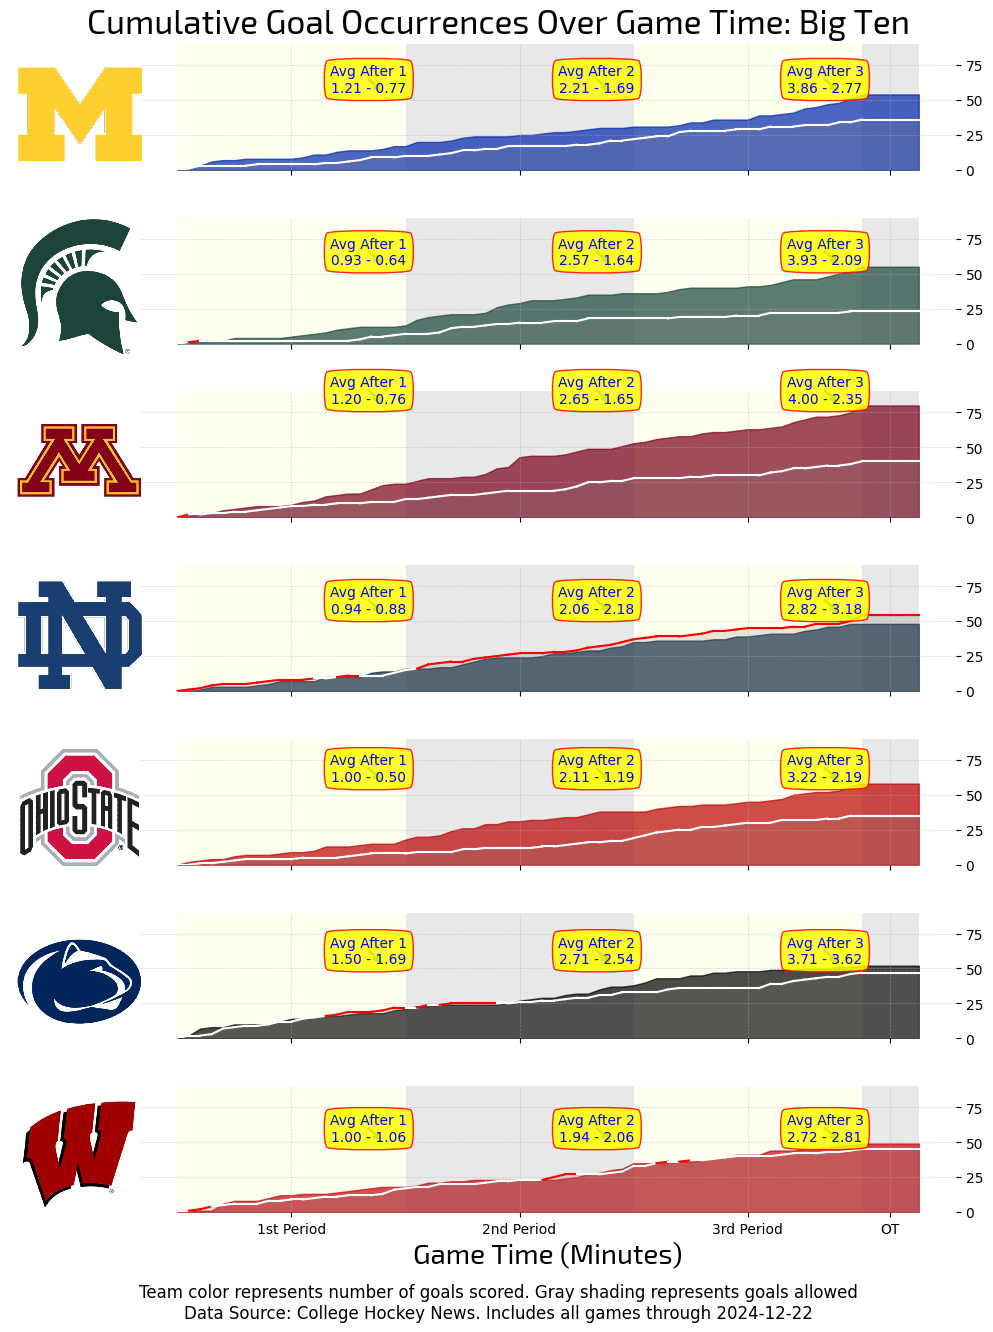

In [90]:

# region_name = "Big Ten Conference"
# Call The Function with the current group
create_cumulative_goal_summary_plot(
    region_name=group_title,
    conn=conn,
    teams_to_plot=teams_to_plot,
    color_mapping=color_mapping,
    base_figure_size=figure_size,
    use_logos_as_y_labels=True
)


In [91]:
# Create team_colors from color_mapping
team_colors = {team: colors[0] for team, colors in color_mapping.items()}

# Print the resulting team_colors dictionary
print(team_colors)


# team_colors
# color_mapping

{'Air Force': '#000000', 'Alaska': '#236192', 'Alaska Anchorage': '#00583d', 'American Intl': '#000000', 'Arizona State': '#8c1d40', 'Army': '#d4bf91', 'Bemidji State': '#004d44', 'Bentley': '#1b5faa', 'Boston College': '#98002e', 'Boston University': '#cc0000', 'Bowling Green': '#fe5000', 'Brown': '#4e3629', 'Canisius': '#0c2340', 'Clarkson': '#0d433b', 'Colgate': '#821019', 'Colorado College': '#000000', 'Connecticut': '#000e2f', 'Cornell': '#b31b1b', 'Dartmouth': '#046a38', 'Denver': '#8b233b', 'Ferris State': '#ba0c2f', 'Harvard': '#a41034', 'Holy Cross': '#602d89', 'Lake Superior': '#003f87', 'Long Island': '#69b3e7', 'Mass Lowell': '#003da5', 'Massachusetts': '#971b2f', 'Mercyhurst': '#07594d', 'Merrimack': '#000000', 'Miami': '#b61e2e', 'Michigan': '#0027ac', 'Michigan State': '#18453b', 'Michigan Tech': '#000000', 'Minnesota': '#7a0019', 'Minnesota State': '#480059', 'Minnesota Duluth': '#8e0a26', 'New Hampshire': '#000000', 'Niagara': '#582c83', 'North Dakota': '#009a44', 'Nor

#### Line By Line Production

In [92]:
### Legacy Code from Last Year GLI PLotting
set_linewidth = 1
all_color='grey'

away_games_df = pd.read_sql("""
SELECT 
    Away_Team AS Team, 
    COUNT(DISTINCT Game_ID) AS Num_Games_Away
FROM game_details
GROUP BY Away_Team;
""", conn)

home_games_df = pd.read_sql("""
SELECT 
    Home_Team AS Team, 
    COUNT(DISTINCT Game_ID) AS Num_Games_Home
FROM game_details
GROUP BY Home_Team;
""", conn)


games_played_count = pd.merge(away_games_df, home_games_df, how='outer', on='Team')
games_played_count['Num_Games'] = games_played_count['Num_Games_Away'].fillna(0) + games_played_count['Num_Games_Home'].fillna(0)
games_played_count = games_played_count[['Team', 'Num_Games']]

games_played_count.tail()

,Team,Num_Games
59,Union,17
60,Vermont,17
61,Western Michigan,14
62,Wisconsin,18
63,Yale,10


In [93]:
# Query to get line-specific stats for goals, assists, and penalty minutes scored for each team,
# now also including the Position column to distinguish between Forwards and Defensemen
line_goals_assists_pim_position_query = """
SELECT
    lc.Team,
    lc.Line,
    lc.Position,
    SUM(ps.G) AS Total_Goals,
    SUM(ps.A) AS Total_Assists,
    SUM(ps.Sh) AS Total_Shots,
    SUM(ps.G) + SUM(ps.A) AS Total_Points,
    SUM(ps.plus_minus) AS Total_Plus_Minus,
    SUM(ps.PIM) AS Total_PIM
FROM line_chart AS lc
LEFT JOIN player_stats AS ps ON lc.Game_ID = ps.Game_ID AND lc.Team = ps.Team AND lc.Player = ps.Player
WHERE lc.Position != 'Goalie'
GROUP BY lc.Team, lc.Line, lc.Position
ORDER BY lc.Team, lc.Line, lc.Position;
"""

# Execute the query and store the results in a DataFrame
line_goals_assists_pim_position_df = pd.read_sql(line_goals_assists_pim_position_query, conn)

# Step 1: Create 'Type' column
line_goals_assists_pim_position_df['Type'] = line_goals_assists_pim_position_df['Position'].apply(
    lambda x: 'Forward' if x in ['Left Wing', 'Right Wing', 'Center'] else 'Defense'
)

# Step 2: Aggregate again by 'Type'
agg_columns = ['Total_Goals', 'Total_Assists', 'Total_PIM', 'Total_Points', 'Total_Shots', 'Total_Plus_Minus']
grouped_df = line_goals_assists_pim_position_df.groupby(['Team', 'Line', 'Type'])[agg_columns].sum().reset_index()

# Now, you can merge the 'Num_Games' and calculate the averages as before
grouped_df = pd.merge(grouped_df, games_played_count, how='left', on='Team')

# Calculate the average stats per game
grouped_df['AVG_Goals'] = grouped_df['Total_Goals'] / grouped_df['Num_Games']
grouped_df['AVG_Assists'] = grouped_df['Total_Assists'] / grouped_df['Num_Games']
grouped_df['AVG_Points'] = grouped_df['Total_Points'] / grouped_df['Num_Games']
grouped_df['AVG_PIM'] = grouped_df['Total_PIM'] / grouped_df['Num_Games']
grouped_df['AVG_Shots'] = grouped_df['Total_Shots'] / grouped_df['Num_Games']
grouped_df['AVG_Plus_Minus'] = grouped_df['Total_Plus_Minus'] / grouped_df['Num_Games']


# Rename grouped_df to line_goals_assists_pim_position_df
line_goals_assists_pim_position_df = grouped_df

C:\Users\jbanc\AppData\Local\Temp\ipykernel_13244\200522111.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Line', y=stat, hue='Team', data=data,
C:\Users\jbanc\AppData\Local\Temp\ipykernel_13244\200522111.py:8: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  sns.barplot(x='Line', y=stat, hue='Team', data=data,
c:\Users\jbanc\anaconda3\envs\data_viz\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jbanc\anaconda3\envs\data_viz\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a

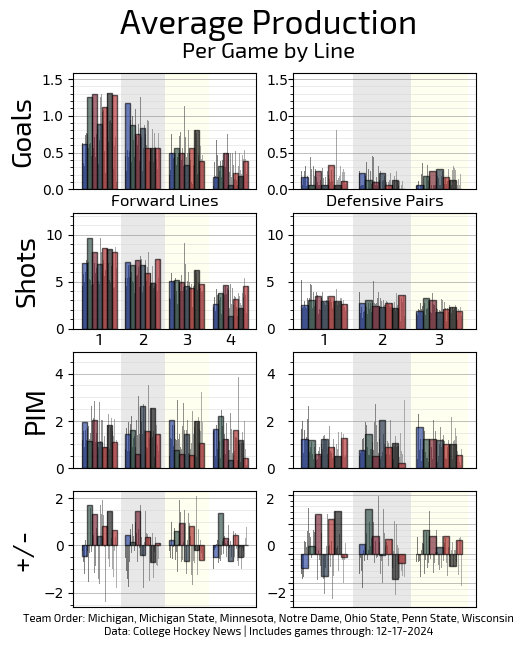

In [94]:
# create a list called team_order to order the teams in the plot - use the default order from teams_to_plot
team_order = teams_to_plot



# Function to plot data
def plot_data(data, stat, ax, team_colors, set_linewidth):
    sns.barplot(x='Line', y=stat, hue='Team', data=data, 
                color=all_color, alpha=0.6, ax=ax, ci=None)
    sns.barplot(x='Line', y=stat, hue='Team', 
    # data=data[data['Team'].isin([team_1, team_2, team_3, team_4])],
    # Use the teams_to_plot list to filter the data
    data=data[data['Team'].isin(teams_to_plot)],

                palette=team_colors, ax=ax, ci=None, alpha=0.6, edgecolor='black', linewidth=set_linewidth, hue_order=team_order)
    

# Function to add background shading
def add_background_shading(ax, x_breaks, colors):
    for i, color in zip(x_breaks, colors):
        ax.axvspan(i[0], i[1], facecolor=color, alpha=0.5, zorder=0)

# Data Prep
forwards_data = line_goals_assists_pim_position_df[line_goals_assists_pim_position_df['Type'] == 'Forward']
defense_data = line_goals_assists_pim_position_df[line_goals_assists_pim_position_df['Type'] == 'Defense']
defense_data = defense_data[defense_data['Line'] != '4']

# Plot Layout
fig, ax = plt.subplots(4, 2, figsize=(5.2, 6))

# Plotting AVG STATS 
stats = ['AVG_Goals', 'AVG_Shots', 'AVG_PIM', 'AVG_Plus_Minus']
for i, stat in enumerate(stats):
    plot_data(forwards_data, stat, ax[i, 0], team_colors, set_linewidth)
    plot_data(defense_data, stat, ax[i, 1], team_colors, set_linewidth)

    # Background shading
    forward_x_breaks = [(0.5, 1.5), (1.5, 2.5), (2.5, 3.5), (3.5, 4.5)]
    defense_x_breaks = [(0.5, 1.5), (1.5, 2.5), (2.5, 3.5)]
    colors = ['lightgrey', 'lightyellow']
    add_background_shading(ax[i, 0], forward_x_breaks, colors)
    add_background_shading(ax[i, 1], defense_x_breaks, colors)




# # Plotting TOTALS IN PLACE OF AVG
# stats = ['Total_Goals', 'Total_Shots', 'Total_PIM', 'Total_Plus_Minus']
# for i, stat in enumerate(stats):
#     plot_data(forwards_data, stat, ax[i, 0], team_colors, set_linewidth)
#     plot_data(defense_data, stat, ax[i, 1], team_colors, set_linewidth)

#     # Background shading
#     forward_x_breaks = [(0.5, 1.5), (1.5, 2.5), (2.5, 3.5), (3.5, 4.5)]
#     defense_x_breaks = [(0.5, 1.5), (1.5, 2.5), (2.5, 3.5)]
#     colors = ['lightgrey', 'lightyellow']
#     add_background_shading(ax[i, 0], forward_x_breaks, colors)
#     add_background_shading(ax[i, 1], defense_x_breaks, colors)


# After plotting all data, adjust y-axis limits
for i in range(3): # Assuming 4 rows of subplots - the last is plus minus with neg values and thisis causing problem
    max_ylim = max(ax[i, 0].get_ylim()[1], ax[i, 1].get_ylim()[1]) # Find the maximum y limit in the row
    ax[i, 0].set_ylim(0, max_ylim) # Set y-axis limit for forwards
    ax[i, 1].set_ylim(0, max_ylim) # Set y-axis limit for defense




###########################

# ax[0, 0].set_ylabel('Goals', font_label_large_param)
# ax[1, 0].set_ylabel('Shots', font_label_large_param)
# ax[2,0].set_ylabel('PIM', font_label_large_param)
# ax[3,0].set_ylabel('+/-', font_label_large_param)

# # Remove Y Labels Defence plots
# ax[0, 1].set_ylabel('')
# ax[1, 1].set_ylabel('')
# ax[2,1].set_ylabel('')
# ax[3,1].set_ylabel('')

# # switch side of plot tick labels are on for all
# ax[0, 0].tick_params(axis='y', labelleft=False, labelright=True)
# ax[0, 1].tick_params(axis='y', labelleft=False, labelright=False)
# ax[1, 0].tick_params(axis='y', labelleft=False, labelright=True)
# ax[1, 1].tick_params(axis='y', labelleft=False, labelright=False)
# ax[2,0].tick_params(axis='y', labelleft=False, labelright=True)
# ax[2,1].tick_params(axis='y', labelleft=False, labelright=False)
# ax[3,0].tick_params(axis='y', labelleft=False, labelright=True)
# ax[3,1].tick_params(axis='y', labelleft=False, labelright=False)

# # Set x tick marks to off on all plots
# ax[0, 0].tick_params(axis='x', which='major', length=0)
# ax[0, 1].tick_params(axis='x', which='major', length=0)
# ax[1, 0].tick_params(axis='x', which='major', length=0)
# ax[1, 1].tick_params(axis='x', which='major', length=0)
# ax[2,0].tick_params(axis='x', which='major', length=0)
# ax[2,1].tick_params(axis='x', which='major', length=0)
# ax[3,0].tick_params(axis='x', which='major', length=0)
# ax[3,1].tick_params(axis='x', which='major', length=0)


# # change font size of tick labels
# ax[0, 0].tick_params(axis='both', which='major', labelsize=10)
# ax[0, 1].tick_params(axis='both', which='major', labelsize=10)
# ax[1, 0].tick_params(axis='both', which='major', labelsize=10)
# ax[1, 1].tick_params(axis='both', which='major', labelsize=10)


# Set Labels
# Y-axis labels for the left column
y_labels = ['Goals', 'Shots', 'PIM', '+/-']
for i, label in enumerate(y_labels):
    ax[i, 0].set_ylabel(label, font_label_large_param)  # Set labels on left column
    ax[i, 1].set_ylabel('')  # Clear labels on right column

# Adjust Y-axis tick label placement and visibility
for i in range(4):
    for j in range(2):  # Iterate over both columns
        ax[i, j].tick_params(axis='y', labelleft=(j == 0), labelright=(j == 0))
        ax[i, j].tick_params(axis='x', which='major', length=0)  # Remove x tick marks
        ax[i, j].tick_params(axis='both', which='major', labelsize=10)  # Set font size



# Remove X Labels from all plots
ax[0, 0].set_xlabel('', font_label_param)
ax[0, 1].set_xlabel('', font_label_param)
ax[1, 0].set_xlabel('', font_label_param)
ax[1, 1].set_xlabel('', font_label_param)
ax[2,0].set_xlabel('', font_label_param)
ax[2,1].set_xlabel('', font_label_param) 


#################
### ADD GRID MARKS
data = line_goals_assists_pim_position_df

for i in range(4):
    for j in range(2):
        

        # Set grid lines to go behind plot elements
        ax[i, j].set_axisbelow(True)

        # Add major grid lines
        ax[i, j].grid(
            color='grey', 
            linestyle='-', 
            linewidth=0.5, 
            alpha=0.7, 
            which='major', 
            axis='y'
        )

        # Add minor grid lines
        ax[i, j].minorticks_on()  # Enable minor ticks
        ax[i, j].grid(
            color='lightgrey',
            linestyle='-',
            linewidth=0.5,
            alpha=0.6,
            which='minor',
            axis='y'
        )


########### LEGEND CODE
######## OLD CODE
# Simplify the legend (example for the first subplot)
handles, labels = ax[0, 0].get_legend_handles_labels()
ax[0, 0].legend(handles[-2:], labels[-2:], title='Team')

# Remove Legend
for axis in ax.flat:
    if axis.get_legend() is not None:
        axis.get_legend().remove()

    save_path = f'{TEMP_FOLDER}'
os.makedirs(save_path, exist_ok=True)  # Create directory if doesn't exist

## Get the string of the title and replace spaces with underscores
title = plt.gca().get_title().replace(' ', '_')

### ADD TITLE TO PLOT
## NEW METHOD
### ADD MAIN TITLE AND SUBTITLE TO PLOT ###
main_title = "Average Production"
subtitle = "Per Game by Line"

# Add the main title
fig.text(
    0.5, 0.98,                   # Position: centered horizontally, near the top
    main_title,                  # Main title text
    ha='center', va='center',    # Center align
    **font_title_param           # Use the large font parameters
)

# Add the subtitle just below the main title
fig.text(
    0.5, 0.935,                  # Position: slightly lower than the main title
    subtitle,                    # Subtitle text
    ha='center', va='center',    # Center align
    **font_tick_param           # Use the smaller font parameters
)

# Adjust layout to ensure space for the titles
plt.subplots_adjust(top=0.90)  # Add space for the titles

###### ADD NOTE TO BOTTOM OF PLOT
# Refactored Tick and X-axis Label Handling
# Remove tick marks and labels except for the 2nd row
for i in range(4):  # Iterate through all subplot rows
    for j in range(2):  # Iterate through 2 columns
        if i != 1:  # Skip the 2nd row (index 1)
            ax[i, j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            ax[i, j].set_xlabel('')  # Remove x-axis labels (text)


## Add back one set of xticks and labels in a small font size between the 2nd and 3rd row
ax[0,0].set_xlabel('Forward Lines', **font_tick_param_small)
ax[0,1].set_xlabel('Defensive Pairs', **font_tick_param_small)

# Add back the tick labels (but without tick marks) in the same subplots
# Set tick labels explicitly for each subplot
# For the "Forward Lines" subplot
forward_ticks = sorted(forwards_data['Line'].unique())  # Unique Line values for Forward Lines
ax[1, 0].set_xticks(range(len(forward_ticks)))  # Set ticks at [0, 1, 2, 3] (center positions)
ax[1, 0].set_xticklabels(forward_ticks, **font_tick_param_small)

# For the "Defensive Pairs" subplot
defense_ticks = sorted(defense_data['Line'].unique())  # Unique Line values for Defensive Pairs
ax[1, 1].set_xticks(range(len(defense_ticks)))  # Set ticks at [0, 1, 2] (center positions)
ax[1, 1].set_xticklabels(defense_ticks, **font_tick_param_small)

# Remove tick marks (lines) but keep the labels centered
for axis in [ax[1, 0], ax[1, 1]]:
    axis.tick_params(axis='x', which='both', length=0)  # Remove tick marks


# Add a note below the last plot using fig.text
set_date = "12-17-2024"  # Replace with your dynamic date
team_order_str = ", ".join(team_order)  # Convert team_order to a comma-separated string

fig.text(
    0.5, -0.02,  # Position: centered horizontally, below the figure
    f"Team Order: {team_order_str}\nData: College Hockey News | Includes games through: {set_date}",
    ha='center',  # Center align the text
    va='center',  # Vertically center it at the position
    **font_note_param  # Use your predefined font parameters
)

# Adjust layout to ensure space for the note
plt.subplots_adjust(bottom=0.01)


# Save Plot
# plt.savefig(f'{TEMP_FOLDER}Line_by_Line.png', bbox_inches='tight', dpi=dpi, transparent=True) #TURN ON TRANPARENTCY WITH THIS


# Show the plot
plt.show()